# Imports + Basic Setup

In [64]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
import tensorflow as tf
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

In [65]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [66]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [67]:
def load_and_split_data(filepath):
    
    # Load data
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Create time features
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Define features and target
    target = 'ENGLAND_WALES_DEMAND'
    
    time_features = ['hour', 'day', 'month', 'year', 'is_weekend', 'weekday']
    weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                        'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    grid_features = [
        'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
        'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
        'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
        'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
        'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
        'VIKING_FLOW', 'GREENLINK_FLOW'
    ]
    
    feature_cols = weather_features + time_features + grid_features
    
    # Drop NaN
    model_df = df.dropna(subset=feature_cols + [target]).copy()
    
    # Temporal split: 2023-2024 = train, 2025 = test
    train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime").reset_index(drop=True)
    test_df = model_df[model_df.year == 2025].sort_values("datetime").reset_index(drop=True)
    
    print(f"✓ Data loaded: Train={len(train_df)}, Test={len(test_df)}")
    print(f"✓ Features: {len(feature_cols)}, Target: {target}")
    
    return train_df, test_df, feature_cols, target,model_df


# EDA

In [68]:
# 1. check missing values

In [69]:
# df.isnull().sum()

In [70]:
# 2. check duplicates

In [71]:
# df.duplicated().sum()

In [72]:
# # Select only rows with duplicated datetime
# duplicate_rows = df[df['datetime'].duplicated(keep=False)]

# #Duplicate SETTLEMENT_DATE and datetime
# duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

In [73]:
# # 3. check for impossible values eg negative energy demand or solar/wind generation
# #negative value for demand
# demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

# neg_demand=df[(df[demand_cols]<0).any(axis=1)]
# print(f"Negative:          {len(neg_demand)} rows")

In [74]:
# #wind generation > capacity
# exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

# #solar generation> capacity
# exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

# print(f"Exceed Wind:          {len(exceed_wind)} rows")

# print(f"Exceed Solar:          {len(exceed_solar)} rows")

In [75]:
# # Temperature spikes
# temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# # Wind spikes
# wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

# #Huminity
# humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# # pressure
# pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# # wind direction
# wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# # precipitation
# precipitation_negative = df[df['precipitation'] < 0]

# print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
# print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
# print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
# print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
# print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
# print(f"Negative precipitation:           {len(precipitation_negative)} rows")

In [76]:
# #mismatch date and time
# df['SETTLEMENT_DATE'] = (
#     pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
#       .dt.tz_convert("Europe/London")
# )

# settlement_dates = df['SETTLEMENT_DATE'].dt.date
# datetime_dates   = df['datetime'].dt.date

# mismatch = df[settlement_dates != datetime_dates]

# print(mismatch[['SETTLEMENT_DATE', 'datetime']])

In [77]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

In [78]:
# import matplotlib.pyplot as plt

# df_2023=df[df['datetime'].dt.year==2023]
# df_2024=df[df['datetime'].dt.year==2024]
# df_2025=df[df['datetime'].dt.year==2025]

# fig,axes=plt.subplots(3,1,figsize=(16,12))

# #2023
# axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
# axes[0].set_title('England & Wales Demand 2023')
# axes[0].set_xlabel('')
# axes[0].set_ylabel('MW')
# axes[0].grid(True)

# #2024
# axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
# axes[1].set_title('England & Wales Demand 2024')
# axes[1].set_xlabel('')
# axes[1].set_ylabel('MW')
# axes[1].grid(True)

# #2025
# axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
# axes[2].set_title('England & Wales Demand 2025')
# axes[2].set_xlabel('')
# axes[2].set_ylabel('MW')
# axes[2].grid(True)

# plt.tight_layout()
# plt.show()

In [79]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import MSTL


# df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
# df['datetime'] = df['datetime'].dt.tz_localize(None)
# df = df.set_index('datetime')



# ts = df['ENGLAND_WALES_DEMAND']

# mstl = MSTL(
#     ts,
#     periods=[48, 336],
#     stl_kwargs={
#         "seasonal_deg": 1,
#         "trend_deg": 1,
#         "trend_jump": 5
#     }
# )

# res = mstl.fit()


# trend = res.trend
# seasonal_daily = res.seasonal['seasonal_48']
# seasonal_weekly = res.seasonal['seasonal_336']
# residual = res.resid


# fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

# axes[0].plot(trend, linewidth=0.9)
# axes[0].set_title('Trend')

# axes[1].plot(seasonal_daily, linewidth=0.9)
# axes[1].set_title('Daily Seasonality (48)')

# axes[2].plot(seasonal_weekly, linewidth=0.9)
# axes[2].set_title('Weekly Seasonality (336)')

# axes[3].plot(residual, linewidth=0.7)
# axes[3].set_title('Residual')

# plt.tight_layout()
# plt.show()

In [80]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

In [81]:
# fig,axes=plt.subplots(1,3,figsize=(18,5))
# sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
# axes[0].set_title('Demand by Hour of Day')
# sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
# axes[1].set_title('Demand by Day of Week')
# sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
# axes[2].set_title('Demand by Month of Year')
# plt.tight_layout
# plt.show()

In [82]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

In [83]:
# weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
# fig,axes=plt.subplots(2,2,figsize=(15,10))
# axes=axes.flatten()
# for i,col in enumerate(weather_vars):
#     sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
#     axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
# plt.tight_layout()
# plt.show()


In [84]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [85]:
# # Select key variables
# key_vars = [
#     "ENGLAND_WALES_DEMAND",
#     "EMBEDDED_WIND_GENERATION",
#     "EMBEDDED_SOLAR_GENERATION",
#     "NON_BM_STOR",
#     "temperature_2m",
#     "relativehumidity_2m",
#     "pressure_msl",
#     "wind_speed_10m",
#     "wind_direction_10m",
#     "precipitation"
# ]

# # Filter only variables that actually exist in the dataframe
# key_vars = [v for v in key_vars if v in df.columns]

# # Compute summary statistics
# summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# # Print Summary
# print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
# print(summary.round(2))

In [86]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [87]:
# # Select variables for distribution plots
# dist_vars = [
#     "ENGLAND_WALES_DEMAND",
#     "temperature_2m",
#     "wind_speed_10m",
#     "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
# ]

# # Plot settings
# plt.style.use("seaborn-v0_8")
# plt.figure(figsize=(14, 10))

# for i, var in enumerate(dist_vars, 1):
#     plt.subplot(2, 2, i)
#     sns.histplot(df[var].dropna(), kde=True, bins=40)
#     var_name = var.replace("_", " ").lower()
#     plt.title(f"Distribution of {var_name}")
#     plt.xlabel(var)
#     plt.ylabel("Frequency")

# plt.tight_layout()
# plt.show()


In [88]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

In [89]:
# # Ensure your datetime column is in datetime format
# # df['datetime'] = pd.to_datetime(df['datetime'])

# # Extract month from datetime
# # df['month'] = df.index.month


# # Set plot style
# # plt.style.use("seaborn-v0_8")
# plt.figure(figsize=(12, 6))

# # Create box plot
# sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
# plt.title('ENGLAND WALES DEMAND by Month')
# plt.xlabel('Month')
# plt.ylabel('Electricity Demand (MW)')
# plt.xticks(ticks=range(12), labels=[
#     'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
# ])
# plt.show()

In [90]:
# 10. correlation
# check pearson correlation between Demand and weather variables

In [91]:
# corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
# plt.figure(figsize=(10,8))
# sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
# plt.title('Correlation Matrix')
# plt.show()

In [92]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [93]:
# from statsmodels.tsa.stattools import adfuller
# series=df['ENGLAND_WALES_DEMAND'].dropna()
# result=adfuller(series.iloc[:10000],autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# if result[1] <= 0.05:
#     print("The time series is stationary.")
# else:
#     print("The time series is non-stationary.")

In [94]:
# target_col='ENGLAND_WALES_DEMAND'
# window_size=48*7  # one week of half-hourly data

# if 'datetime' not in df.columns:
#     df = df.reset_index()

# rolling_mean=df[target_col].rolling(window=window_size).mean()
# rolling_std=df[target_col].rolling(window=window_size).std()


# plt.figure(figsize=(15,8))
# plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
# plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
# plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
# plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
# plt.xlabel('Date')
# plt.ylabel('Demand(MW)')
# plt.legend(loc='best')
# plt.grid(True,which='both', linestyle='--', linewidth=0.5)

# plt.tight_layout()
# plt.show()
# print("#remark")
# print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
# print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
# print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Preprocessing function

In [95]:
def iqr_clip_df(df_in, cols):
    """Clip outliers using IQR method"""
    df = df_in.copy()
    clip_info = {}
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
        clip_info[c] = (lower, upper)
    return df, clip_info


def create_lag_features(df, target_col, lag_list):
    """Create lagged features for target variable"""
    df_out = df.copy()
    for lag in lag_list:
        df_out[f'{target_col}_lag_{lag}'] = df_out[target_col].shift(lag)
    return df_out

def create_cyclical_encoding(df, cyclical_cols_info):
    """Create sin/cos encoding for cyclical features"""
    df_out = df.copy()
    for col, max_val in cyclical_cols_info.items():
        if col in df_out.columns:
            df_out[f'{col}_sin'] = np.sin(2 * np.pi * df_out[col] / max_val)
            df_out[f'{col}_cos'] = np.cos(2 * np.pi * df_out[col] / max_val)
    return df_out


#/////
def combined_ranking_feature_selection(df, target_col, K=15, mi_random_state=42):
    """
    Selects top K features based on a combined rank score from Pearson,
    Spearman, and Mutual Information (MI) correlation metrics.

    Args:
        df_in (pd.DataFrame): The input DataFrame containing features and target.
        target_col (str): The name of the target column.
        K (int): The number of top features to select.
        mi_random_state (int): Random state for reproducibility of MI calculation.

    Returns:
        list: A list of the top K selected feature names.
    """
    df = df.copy().select_dtypes(include=np.number)
    features = [col for col in df.columns if col != target_col]
    X = df[features]
    y = df[target_col]
    n_features = len(features)
    
    # 1. Initialize Rank DataFrame
    rank_df = pd.DataFrame(index=features)
    
    # --- A. Pearson Rank (Linear) ---
    pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
    rank_df['Pearson_Score'] = pearson_scores
    # Rank: Lower rank is better (i.e., higher score)
    rank_df['Pearson_Rank'] = pearson_scores.rank(ascending=False, method='min')

    # --- B. Spearman Rank (Monotonic Nonlinear) ---
    spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()
    rank_df['Spearman_Score'] = spearman_scores
    rank_df['Spearman_Rank'] = spearman_scores.rank(ascending=False, method='min')

    # --- C. Mutual Information (General Nonlinear) ---
    # MI requires the input features X to be a numpy array, and the target y must be 1D.
    # We must treat features as continuous for mi_regression.
    try:
        # MI is sensitive to scaling, but mi_regression handles it somewhat.
        # It's good practice to ensure non-negative inputs if possible, but not strictly required.
        mi_scores = mutual_info_regression(
            X, 
            y, 
            random_state=mi_random_state, 
            n_neighbors=5 # default setting
        )
        mi_scores = pd.Series(mi_scores, index=features)
    except ValueError as e:
        print(f"Error during Mutual Information calculation: {e}. Are there non-numeric/NaN values?")
        return []

    rank_df['MI_Score'] = mi_scores
    rank_df['MI_Rank'] = mi_scores.rank(ascending=False, method='min')

    # --- 2. Combine Ranks (Average Rank) ---
    rank_df['Combined_Rank'] = rank_df[['Pearson_Rank', 'Spearman_Rank', 'MI_Rank']].mean(axis=1)
    
    # Sort by the combined rank (lowest rank/score is best)
    rank_df = rank_df.sort_values('Combined_Rank', ascending=True)

    # --- 3. Keep top K ---
    selected_features = rank_df.head(K).index.tolist()
    
    print("\n--- Feature Ranking Summary (Top K) ---")
    print(rank_df[['Pearson_Rank', 'Spearman_Rank', 'MI_Rank', 'Combined_Rank']].head(K))

    return selected_features


# --- Integration into your feature_selection stub ---

def feature_selection(df, target_col, K=10):
    
    # Get the list of top K selected features
    selected_cols = combined_ranking_feature_selection(
        df=df, 
        target_col=target_col, 
        K=K
    )
    
    # Ensure the target column is included in the final output
    if target_col not in selected_cols:
        selected_cols.append(target_col)
        
    return df[selected_cols]



## feture_selection

In [96]:
# selected_cols=feature_selection(model_df,'ENGLAND_WALES_DEMAND')

In [97]:
def preprocess_data(train_df, test_df, feature_cols, target, 
                   apply_iqr=True, apply_lags=True, apply_cyclical=True):
    
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    current_feature_cols = feature_cols.copy()
    
    # Step 1: IQR Clipping
    if apply_iqr:
        print("\nStep 1: IQR Clipping...")
        train_processed[current_feature_cols], clip_info = iqr_clip_df(
            train_processed[current_feature_cols], 
            current_feature_cols
        )
        # Apply same clipping bounds to test (using train bounds - NO LEAKAGE)
        for col, (lower, upper) in clip_info.items():
            test_processed[col] = test_processed[col].clip(lower, upper)
        print(f"✓ Applied IQR clipping to {len(current_feature_cols)} features")
    
    # Step 2: Lag Features
    if apply_lags:
        LAG_HOURS = [1, 2, 3, 6, 12, 24]
        print(f"\nStep 2: Adding lag features {LAG_HOURS}...")
        train_processed = create_lag_features(train_processed, target, LAG_HOURS)
        test_processed = create_lag_features(test_processed, target, LAG_HOURS)
        
        lag_cols = [col for col in train_processed.columns if col.startswith(f'{target}_lag_')]
        current_feature_cols.extend(lag_cols)
        print(f"Added {len(lag_cols)} lag features")
    
    # Step 3: Cyclical Encoding
    if apply_cyclical:
        cyclical_info = {'hour': 24, 'day': 31, 'month': 12}
        print(f"\nStep 3: Cyclical encoding for {list(cyclical_info.keys())}...")
        train_processed = create_cyclical_encoding(train_processed, cyclical_info)
        test_processed = create_cyclical_encoding(test_processed, cyclical_info)
        
        cyclical_cols = [col for col in train_processed.columns 
                        if '_sin' in col or '_cos' in col]
        current_feature_cols.extend(cyclical_cols)
        print(f"Added {len(cyclical_cols)} cyclical features")
    
    # Step 4: Drop NaN rows from lagging
    print(f"\nStep 4: Handling NaN from lag features...")
    train_processed = train_processed.dropna(subset=current_feature_cols + [target])
    test_processed = test_processed.dropna(subset=current_feature_cols + [target])
    print(f"Train: {len(train_df)} → {len(train_processed)} samples")
    print(f"Test: {len(test_df)} → {len(test_processed)} samples")

    #step 5: feture selection #add
    
    # Extract final X and y
    X_train = train_processed[current_feature_cols]
    y_train = train_processed[target]
    X_test = test_processed[current_feature_cols]
    y_test = test_processed[target]
    
    print(f"\nFinal shapes: X_train={X_train.shape}, X_test={X_test.shape}")
    print(f"Total features: {len(current_feature_cols)}")
    
    return X_train, X_test, y_train, y_test, current_feature_cols

## Scaling with post-scaling clip

In [98]:
from sklearn.discriminant_analysis import StandardScaler


def scale_data(X_train, X_test, y_train, y_test, clip_value=5.0):
    
    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    
    print(f" Features scaled (mean={scaler_X.mean_[:3].round(2)}, std={scaler_X.scale_[:3].round(2)})")
    print(f" Target scaled (mean={scaler_y.mean_[0]:.2f}, std={scaler_y.scale_[0]:.2f})")
    
    # Post-scaling clip for extreme outliers
    print(f"\nPost-scaling clipping (±{clip_value} std)...")
    
    X_train_scaled_clipped = np.clip(X_train_scaled, -clip_value, clip_value)
    X_test_scaled_clipped = np.clip(X_test_scaled, -clip_value, clip_value)
    
    n_clipped_train = np.sum(np.abs(X_train_scaled) > clip_value)
    n_clipped_test = np.sum(np.abs(X_test_scaled) > clip_value)
    
    if n_clipped_train > 0:
        pct = 100 * n_clipped_train / X_train_scaled.size
        print(f"  Train: Clipped {n_clipped_train} values ({pct:.3f}%)")
    else:
        print(f"  Train: No values exceeded ±{clip_value}")
    
    if n_clipped_test > 0:
        pct = 100 * n_clipped_test / X_test_scaled.size
        print(f"  Test: Clipped {n_clipped_test} values ({pct:.3f}%)")
    else:
        print(f"  Test: No values exceeded ±{clip_value}")
    
    print(f" Final ranges: Train=[{X_train_scaled_clipped.min():.2f}, {X_train_scaled_clipped.max():.2f}], "
          f"Test=[{X_test_scaled_clipped.min():.2f}, {X_test_scaled_clipped.max():.2f}]")
    
    return (X_train_scaled_clipped, X_test_scaled_clipped, 
            y_train_scaled, y_test_scaled, 
            scaler_X, scaler_y)

## Neural Network Classes

In [99]:
class MLP:
    def __init__(self, input_dim, hidden_units=32, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_dim=self.input_dim),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()
    
    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name  
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class LSTM_Model:
    def __init__(self, input_shape, units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()
    
    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name  
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class TemporalCNN:
    def __init__(self, input_shape, filters=32, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters // 2), kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()
    
    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name  
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size

## Utility functions

In [100]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def get_model_size_mb(model):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.pkl') as tmp:
            tmp_name = tmp.name 
        # File is now closed
        joblib.dump(model, tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size
    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

## Training function for ML

In [101]:
def train_all_models(X_train_scaled, X_test_scaled, 
                    y_train_scaled, y_test_scaled,
                    y_test_original, scaler_y,
                    xgboost_tree_method='hist'):
    """
    Train all models with proper scaling and inverse transforms.
    
    ALL MODELS receive scaled data.
    ALL PREDICTIONS are inverse-transformed back to original scale.
    ALL METRICS are computed on original scale.
    
    Args:
        X_train_scaled, X_test_scaled: Scaled features (numpy arrays)
        y_train_scaled, y_test_scaled: Scaled targets (1D numpy arrays)
        y_test_original: Original scale target for metric computation (pandas Series or array)
        scaler_y: Fitted StandardScaler for target
        xgboost_tree_method: XGBoost tree method
    
    Returns:
        results_df: DataFrame with all model results
        predictions_dict: Dictionary of predictions (original scale)
        models_dict: Dictionary of trained models
    """
    print("\n" + "="*80)
    print("TRAINING ALL MODELS")
    print("="*80)
    
    results_list = []
    predictions_dict = {}
    models_dict = {}
    
    # ========================================================================
    # CLASSICAL ML MODELS (Linear Regression, Ridge, SVR, Tree-based)
    # ========================================================================
    
    classical_models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "SVR": LinearSVR(max_iter=5000),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=xgboost_tree_method
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
    }
    
    for name, model in classical_models.items():
        print(f"\n{'='*60}")
        print(f"Training: {name}")
        print(f"{'='*60}")
        
        # Train on SCALED data
        start_time = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        train_time = time.time() - start_time
        
        # Predict on SCALED data
        start_pred = time.time()
        y_pred_scaled = model.predict(X_test_scaled)
        inference_time = (time.time() - start_pred) / len(X_test_scaled)
        
        # INVERSE TRANSFORM to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        # Compute metrics on ORIGINAL scale
        metrics = compute_metrics(y_test_original, y_pred_original)
        model_size = get_model_size_mb(model)
        
        # Store results
        results_list.append({
            "Model": name,
            **metrics,
            "Training Time (s)": train_time,
            "Inference Time per Sample (s)": inference_time,
            "Model Size (MB)": model_size
        })
        
        predictions_dict[name] = y_pred_original
        models_dict[name] = model
        
        print(f"✓ {name} - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")
    
    # ========================================================================
    # MLP NEURAL NETWORK
    # ========================================================================
    
    print(f"\n{'='*60}")
    print(f"Training: MLP")
    print(f"{'='*60}")
    
    mlp = MLP(input_dim=X_train_scaled.shape[1], hidden_units=32, epochs=50, batch_size=32)
    
    start_time = time.time()
    mlp.fit(X_train_scaled, y_train_scaled, verbose=0)
    train_time = time.time() - start_time
    
    start_pred = time.time()
    y_pred_scaled = mlp.predict(X_test_scaled)
    inference_time = (time.time() - start_pred) / len(X_test_scaled)
    
    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = mlp.get_size_mb()
    
    results_list.append({
        "Model": "MLP",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })
    
    predictions_dict["MLP"] = y_pred_original
    models_dict["MLP"] = mlp
    
    print(f"✓ MLP - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")
    
    # ========================================================================
    # TEMPORAL CNN
    # ========================================================================
    
    print(f"\n{'='*60}")
    print(f"Training: Temporal CNN")
    print(f"{'='*60}")
    
    # Reshape for CNN: (samples, timesteps=1, features)
    X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
    X_test_cnn = X_test_scaled.reshape(len(X_test_scaled), 1, -1)
    
    cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]), filters=32, epochs=50, batch_size=32)
    
    start_time = time.time()
    cnn.fit(X_train_cnn, y_train_scaled, verbose=0)
    train_time = time.time() - start_time
    
    start_pred = time.time()
    y_pred_scaled = cnn.predict(X_test_cnn)
    inference_time = (time.time() - start_pred) / len(X_test_cnn)
    
    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = cnn.get_size_mb()
    
    results_list.append({
        "Model": "Temporal CNN",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })
    
    predictions_dict["Temporal CNN"] = y_pred_original
    models_dict["Temporal CNN"] = cnn
    
    print(f"✓ Temporal CNN - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")
    
    # ========================================================================
    # LSTM (REQUIRES SEQUENCES)
    # ========================================================================
    
    print(f"\n{'='*60}")
    print(f"Training: LSTM")
    print(f"{'='*60}")
    
    timesteps = 24
    print(f"Creating sequences with timesteps={timesteps}...")
    
    # Create sequences from SCALED data
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)
    
    print(f"✓ Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")
    
    lstm = LSTM_Model(input_shape=(timesteps, X_train_scaled.shape[1]), units=50, epochs=50, batch_size=32)
    
    start_time = time.time()
    lstm.fit(X_train_seq, y_train_seq, verbose=0)
    train_time = time.time() - start_time
    
    start_pred = time.time()
    y_pred_scaled = lstm.predict(X_test_seq)
    inference_time = (time.time() - start_pred) / len(X_test_seq)
    
    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # For metrics, use the corresponding y_test_original values (skipping first 'timesteps' samples)
    y_test_original_seq = y_test_original.iloc[timesteps:].values if hasattr(y_test_original, 'iloc') else y_test_original[timesteps:]
    
    metrics = compute_metrics(y_test_original_seq, y_pred_original)
    model_size = lstm.get_size_mb()
    
    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })
    
    predictions_dict["LSTM"] = y_pred_original
    models_dict["LSTM"] = lstm
    
    print(f"✓ LSTM - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")
    
    # ========================================================================
    # SUMMARY
    # ========================================================================
    
    results_df = pd.DataFrame(results_list)
    
    print("\n" + "="*80)
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"✓ Trained {len(results_df)} models")
    print(f"✓ All predictions in original scale")
    print(f"✓ All metrics computed on original scale")
    
    return results_df, predictions_dict, models_dict


## Main execution pipeline

In [102]:
def main_pipeline(filepath, 
                 apply_iqr=True, 
                 apply_lags=True, 
                 apply_cyclical=True,
                 clip_value=5.0):
    """
    
    Args:
        filepath: Path to data CSV
        apply_iqr: Whether to apply IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold (std devs)
    
    Returns:
        results_df, predictions_dict, models_dict, scalers, data_dict
    """
    
    # Step 1: Load and split
    train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath)
    
    # Step 2: Preprocess
    X_train, X_test, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=apply_iqr,
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )
    
    # Step 3: Scale
    (X_train_scaled, X_test_scaled, 
     y_train_scaled, y_test_scaled,
     scaler_X, scaler_y) = scale_data(X_train, X_test, y_train, y_test, clip_value=clip_value)
    
    # Step 4: Train all models
    results_df, predictions_dict, models_dict = train_all_models(
        X_train_scaled, X_test_scaled,
        y_train_scaled, y_test_scaled,
        y_test,  # Original scale for metrics
        scaler_y
    )
    
    # Package outputs
    scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}
    data_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train_scaled': y_train_scaled,
        'y_test_scaled': y_test_scaled,
        'feature_cols': feature_cols_final
    }
    
    return results_df, predictions_dict, models_dict, scalers, data_dict


## A. Raw data training

In [103]:
results_raw, preds_raw, models_raw, scalers_raw, data_raw = main_pipeline(
        filepath="merged_energy_weather_data.csv",
        apply_iqr=False,
        apply_lags=False,
        apply_cyclical=False,
        clip_value=5.0
    )
print("\nPart A Results (Raw Data):")
print(results_raw)

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 4: Handling NaN from lag features...
Train: 35088 → 35088 samples
Test: 14545 → 14545 samples

Final shapes: X_train=(35088, 29), X_test=(14545, 29)
Total features: 29
 Features scaled (mean=[  11.76   79.63 1014.12], std=[ 5.9  13.78 11.85])
 Target scaled (mean=24009.69, std=5470.44)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.033%)
  Test: Clipped 13186 values (3.126%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

TRAINING ALL MODELS

Training: Linear Regression
✓ Linear Regression - R²: -2.495212, RMSE: 10172.54

Training: Ridge Regression
✓ Ridge Regression - R²: -2.394270, RMSE: 10024.57

Training: SVR
✓ SVR - R²: -2.760108, RMSE: 10550.98

Training: Decision Tree
✓ Decision Tree - R²: 0.841464, RMSE: 2166.49

Training: XGBoost
✓ XGBoost - R²: 0.912496, RMSE: 1609.56

Training: Random Forest
✓ Random Forest - R²: 0.911072, RMSE: 1622.60

Training: MLP


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ MLP - R²: 0.533294, RMSE: 3717.18

Training: Temporal CNN


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Temporal CNN - R²: 0.842533, RMSE: 2159.17

Training: LSTM
Creating sequences with timesteps=24...
✓ Train sequences: (35064, 24, 29), Test sequences: (14521, 24, 29)


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ LSTM - R²: 0.562095, RMSE: 3601.50

TRAINING COMPLETE
✓ Trained 9 models
✓ All predictions in original scale
✓ All metrics computed on original scale

Part A Results (Raw Data):
               Model          MAE           MSE          RMSE        R2  \
0  Linear Regression  9048.840271  1.034805e+08  10172.537403 -2.495212   
1   Ridge Regression  8909.218294  1.004920e+08  10024.568859 -2.394270   
2                SVR  9398.703916  1.113231e+08  10550.976246 -2.760108   
3      Decision Tree  1632.508422  4.693672e+06   2166.488423  0.841464   
4            XGBoost  1266.289429  2.590688e+06   1609.561353  0.912496   
5      Random Forest  1236.326194  2.632821e+06   1622.597088  0.911072   
6                MLP  2935.894287  1.381746e+07   3717.184015  0.533294   
7       Temporal CNN  1702.950439  4.662019e+06   2159.170906  0.842533   
8               LSTM  2988.765137  1.297078e+07   3601.497189  0.562095   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model 

## B. Post preprocessing training

In [104]:
results_full, preds_full, models_full, scalers_full, data_full = main_pipeline(
        filepath="merged_energy_weather_data.csv",
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )
print("\nPart B Results (Full Preprocessing):")
print(results_full)

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 1: IQR Clipping...
✓ Applied IQR clipping to 29 features

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
 Features scaled (mean=[  11.76   79.65 1014.25], std=[ 5.89 13.73 11.48])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: No values exceeded ±5.0
  Test: No values exceeded ±5.0
 Final ranges: Train=[-2.91, 3.13], Test=[-2.90, 3.53]

TRAINING ALL MODELS

Training: Linear Regression
✓ Linear Regression - R²: 0.993042, RMSE: 453.99

Training: Ridge Regression
✓ Ridge Regression - R²: 0.993060, RMSE: 453.39

Training: SVR


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


✓ SVR - R²: 0.993793, RMSE: 428.77

Training: Decision Tree
✓ Decision Tree - R²: 0.991385, RMSE: 505.15

Training: XGBoost
✓ XGBoost - R²: 0.995712, RMSE: 356.39

Training: Random Forest
✓ Random Forest - R²: 0.995679, RMSE: 357.75

Training: MLP


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ MLP - R²: 0.996088, RMSE: 340.40

Training: Temporal CNN


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Temporal CNN - R²: 0.995885, RMSE: 349.11

Training: LSTM
Creating sequences with timesteps=24...
✓ Train sequences: (35040, 24, 41), Test sequences: (14497, 24, 41)


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ LSTM - R²: 0.984851, RMSE: 669.94

TRAINING COMPLETE
✓ Trained 9 models
✓ All predictions in original scale
✓ All metrics computed on original scale

Part B Results (Full Preprocessing):
               Model         MAE            MSE        RMSE        R2  \
0  Linear Regression  367.054437  206104.749121  453.987609  0.993042   
1   Ridge Regression  366.638611  205562.374018  453.389870  0.993060   
2                SVR  341.939720  183844.663546  428.771109  0.993793   
3      Decision Tree  379.627505  255173.131534  505.146644  0.991385   
4            XGBoost  266.902679  127014.609375  356.391090  0.995712   
5      Random Forest  271.209437  127984.561108  357.749299  0.995679   
6                MLP  265.891937  115871.867188  340.399570  0.996088   
7       Temporal CNN  272.740143  121874.320312  349.105028  0.995885   
8               LSTM  518.463867  448820.843750  669.940926  0.984851   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model Size (MB)  

## C. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [105]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [106]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None
    
    def fit(self, X, y):
        # Initialize MLP with correct input_dim (not input_shape)
        self.mlp_instance = MLP(
            input_dim=X.shape[1],  
            hidden_units=self.hidden_units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.mlp_instance.fit(X, y, verbose=0)  
        return self
    
    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        return self.mlp_instance.predict(X)


class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=32, epochs=50, batch_size=32):
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None
    
    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        
        self.lstm_instance = LSTM_Model(
            input_shape=input_shape,
            units=self.units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.lstm_instance.fit(X_lstm, y, verbose=0)  
        return self
    
    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        return self.lstm_instance.predict(X_lstm)


class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, filters=16, epochs=50, batch_size=32):
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None
    
    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        
        self.cnn_instance = TemporalCNN(
            input_shape=input_shape,
            filters=self.filters,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.cnn_instance.fit(X_cnn, y, verbose=0)  
        return self
    
    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        return self.cnn_instance.predict(X_cnn)

In [107]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}


In [108]:
subsample_ratio = 0.3
N = int(len(data_full['X_train_scaled']) * subsample_ratio) 

# ALL MODELS use scaled data (fix the root problem!)
X_tr_sub_scaled  = data_full['X_train_scaled'][:N].copy()
y_tr_sub_scaled  = data_full['y_train_scaled'][:N].copy()

X_val_sub_scaled = data_full['X_train_scaled'][N:].copy()
y_val_sub_scaled = data_full['y_train_scaled'][N:].copy()

print(f"✓ Training subset: {X_tr_sub_scaled.shape}")
print(f"✓ Validation subset: {X_val_sub_scaled.shape}")
print(f"✓ All data is SCALED (StandardScaler)")

✓ Training subset: (10519, 41)
✓ Validation subset: (24545, 41)
✓ All data is SCALED (StandardScaler)



Training Linear Regression...

Training Ridge Regression...

Training Linear SVR...

Training Decision Tree...

Training Random Forest...

Training XGBoost...

ML MODELS - Complexity vs Error (ALL MODELS ON SCALED DATA):


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,3.654508e-03,6.158446e-02,-5.792995e-02,1
1,Linear Regression,degree=2,1.764204e-03,6.161986e+01,-6.161809e+01,2
2,Linear Regression,degree=3,1.057885e-04,7.997873e+10,-7.997873e+10,3
3,Ridge Regression,alpha=1e-05,3.654508e-03,6.158428e-02,-5.792977e-02,1
4,Ridge Regression,alpha=0.0001,3.654508e-03,6.158264e-02,-5.792813e-02,2
...,...,...,...,...,...,...
85,XGBoost,max_depth=400,1.841945e-07,6.227106e-03,-6.226922e-03,16
86,XGBoost,max_depth=600,1.841945e-07,6.227106e-03,-6.226922e-03,17
87,XGBoost,max_depth=800,1.841945e-07,6.227106e-03,-6.226922e-03,18
88,XGBoost,max_depth=1000,1.841945e-07,6.227106e-03,-6.226922e-03,19



ULTRA-LOW COMPLEXITY RESULTS:


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,3.654508e-03,6.158446e-02,-5.792995e-02,1
1,Linear Regression,degree=2,1.764204e-03,6.161986e+01,-6.161809e+01,2
2,Linear Regression,degree=3,1.057885e-04,7.997873e+10,-7.997873e+10,3
3,Ridge Regression,alpha=1e-05,3.654508e-03,6.158428e-02,-5.792977e-02,1
4,Ridge Regression,alpha=0.0001,3.654508e-03,6.158264e-02,-5.792813e-02,2
...,...,...,...,...,...,...
85,XGBoost,max_depth=400,1.841945e-07,6.227106e-03,-6.226922e-03,16
86,XGBoost,max_depth=600,1.841945e-07,6.227106e-03,-6.226922e-03,17
87,XGBoost,max_depth=800,1.841945e-07,6.227106e-03,-6.226922e-03,18
88,XGBoost,max_depth=1000,1.841945e-07,6.227106e-03,-6.226922e-03,19



✓ Results saved to 'ml_complexity_ultra_low_results.csv'

Generating plots...


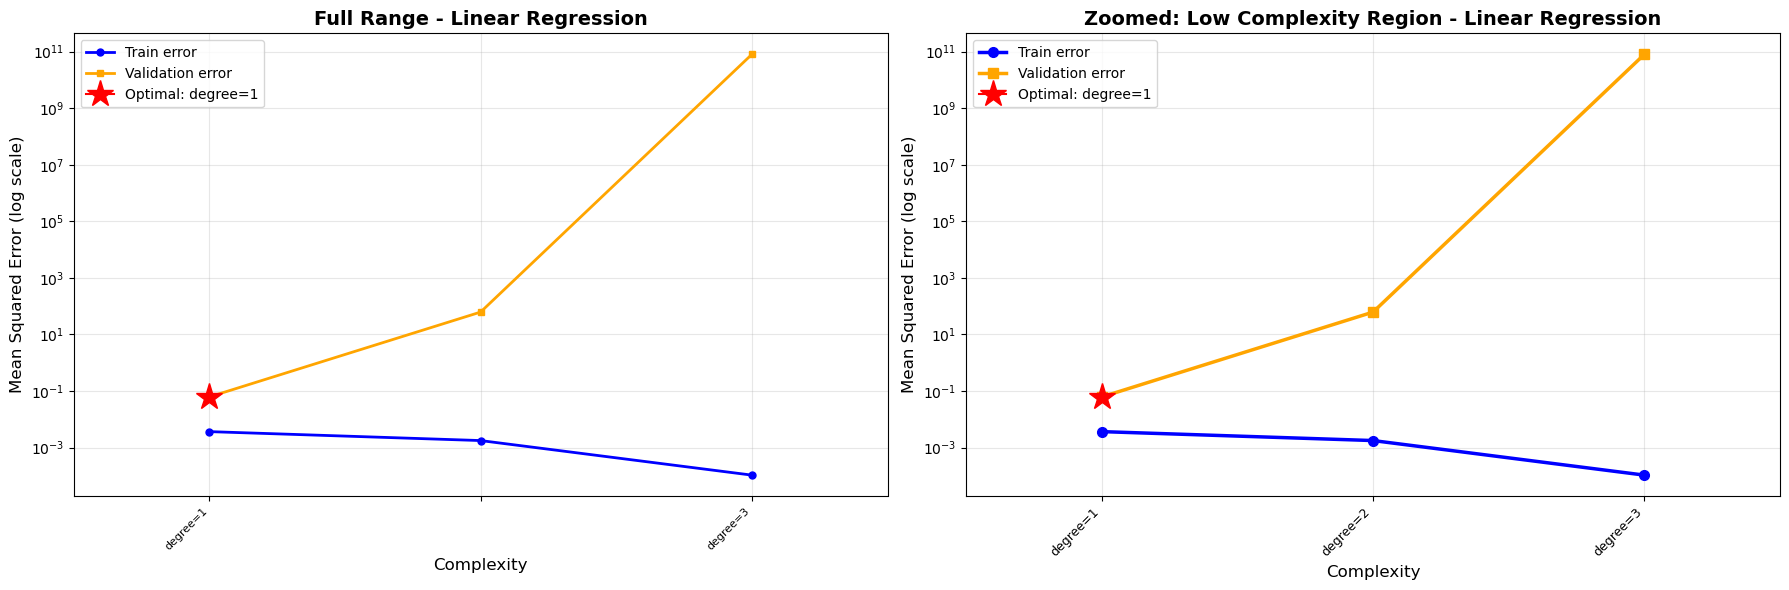

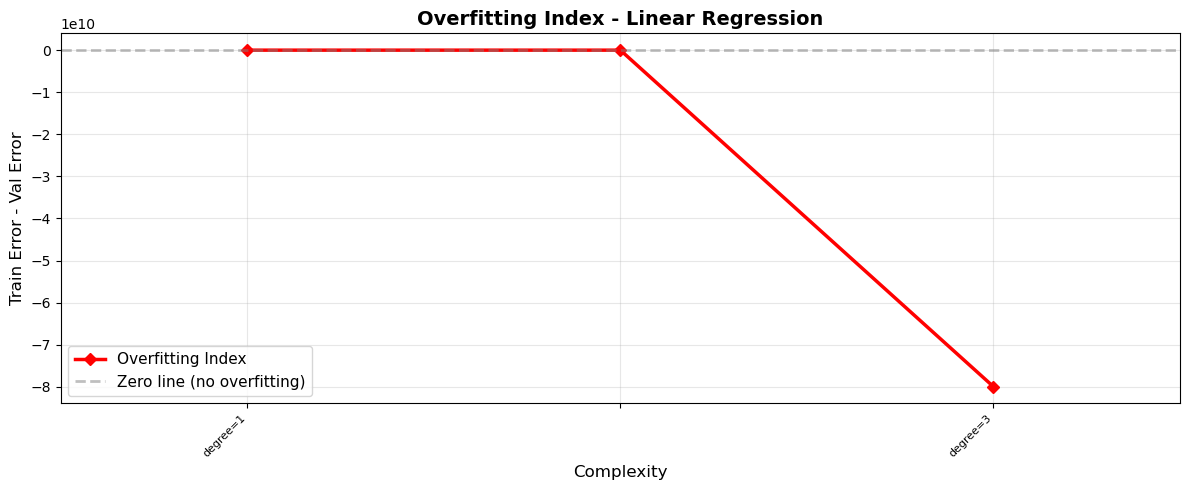


Linear Regression Analysis:
  Lowest complexity tested: degree=1
    Train Error: 0.003655
    Val Error: 0.061584
  Optimal configuration: degree=1
    Train Error: 0.003655
    Val Error: 0.061584
  Highest complexity tested: degree=3
    Train Error: 0.000106
    Val Error: 79978733547.382385
    Overfitting Index: -79978733547.382278
  U-shape detected: YES


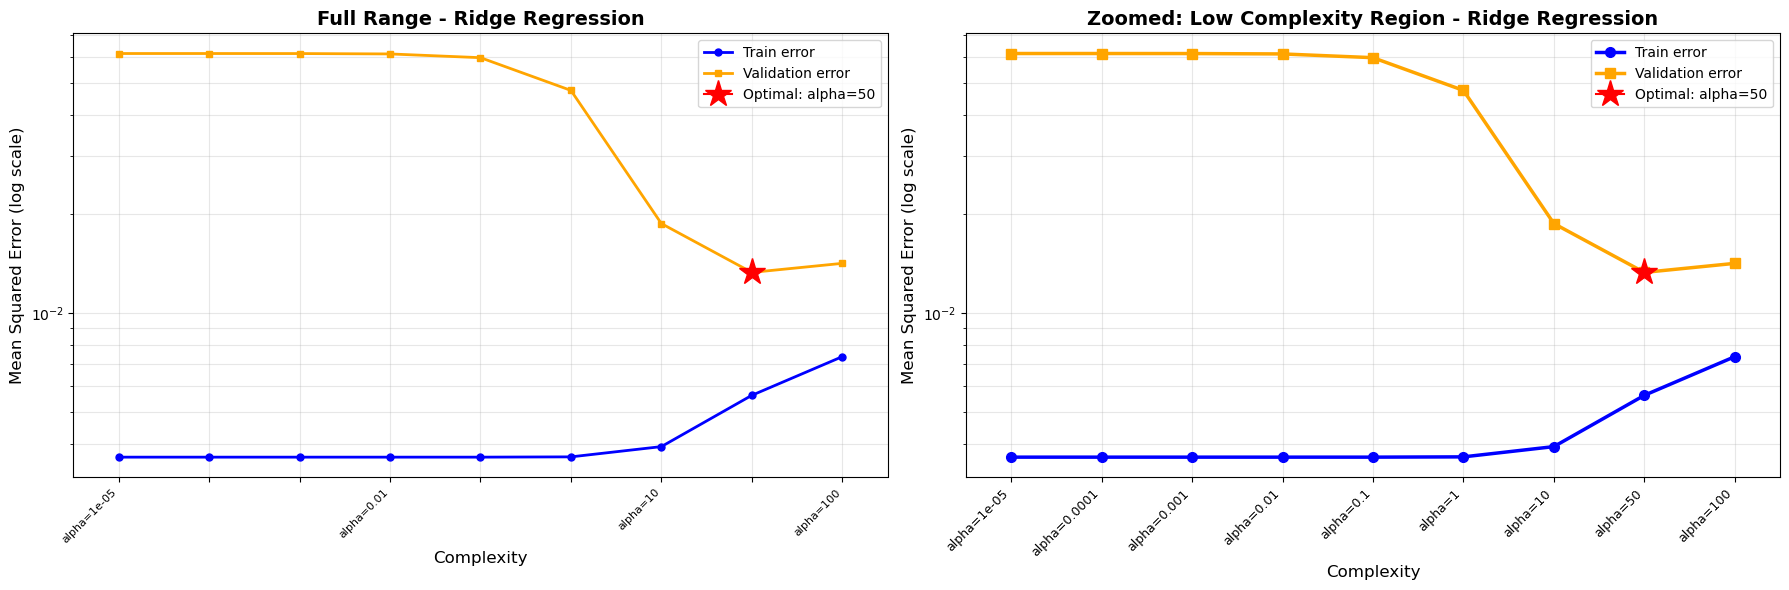

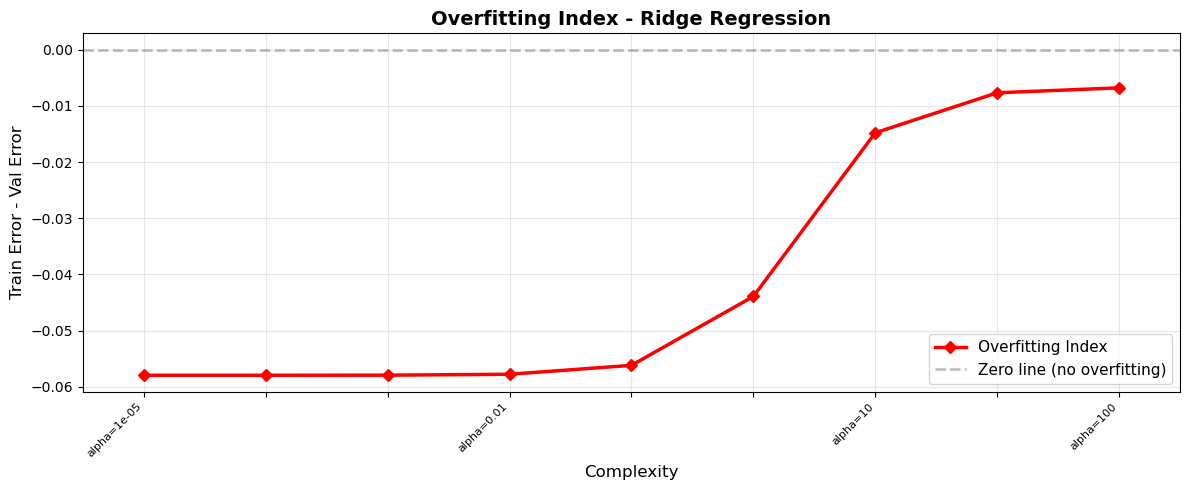


Ridge Regression Analysis:
  Lowest complexity tested: alpha=1e-05
    Train Error: 0.003655
    Val Error: 0.061584
  Optimal configuration: alpha=50
    Train Error: 0.005633
    Val Error: 0.013313
  Highest complexity tested: alpha=100
    Train Error: 0.007383
    Val Error: 0.014183
    Overfitting Index: -0.006800
  U-shape detected: PARTIAL


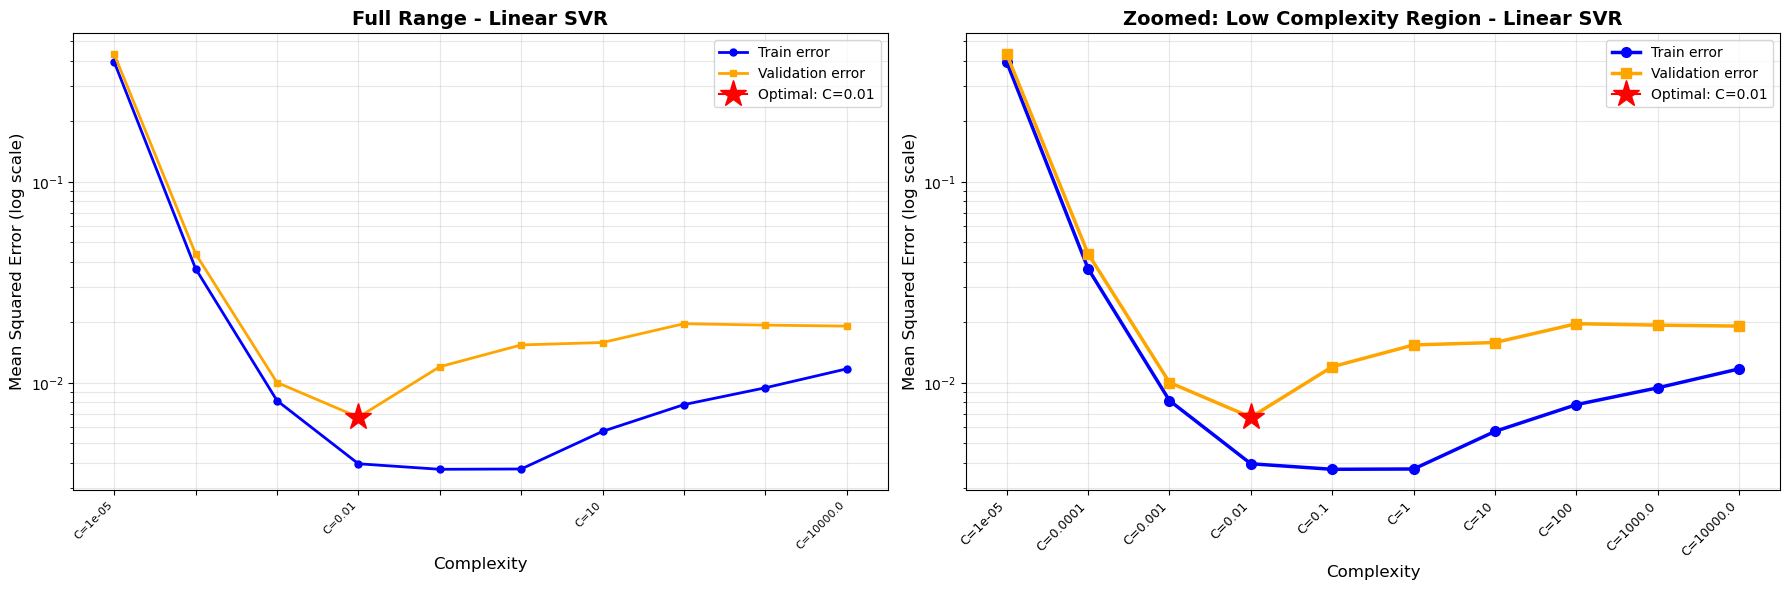

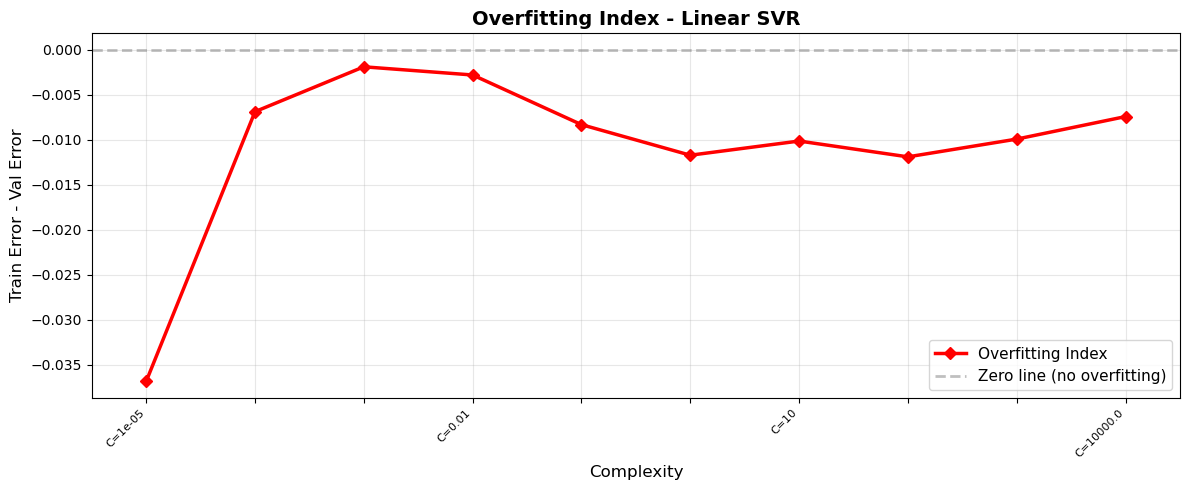


Linear SVR Analysis:
  Lowest complexity tested: C=1e-05
    Train Error: 0.395081
    Val Error: 0.431942
  Optimal configuration: C=0.01
    Train Error: 0.003958
    Val Error: 0.006747
  Highest complexity tested: C=10000.0
    Train Error: 0.011741
    Val Error: 0.019155
    Overfitting Index: -0.007414
  U-shape detected: YES


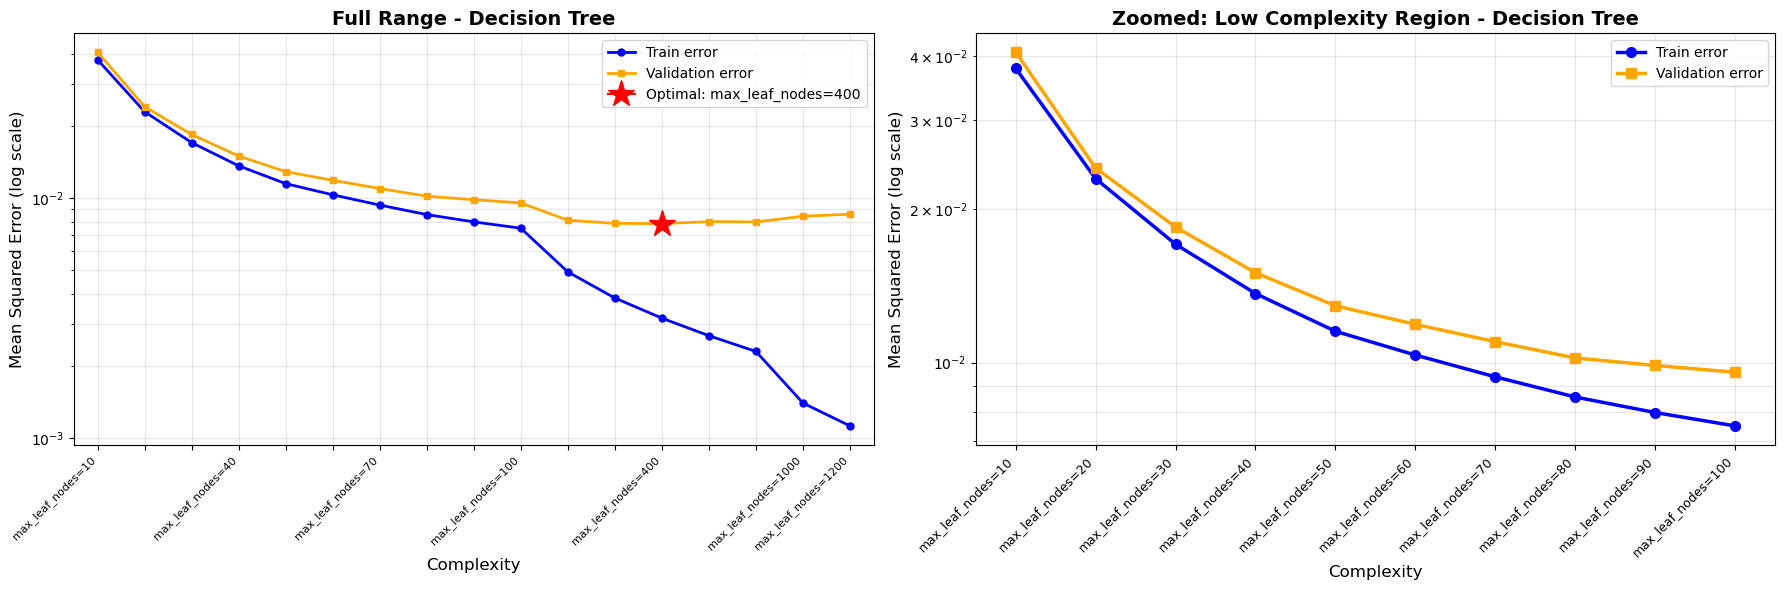

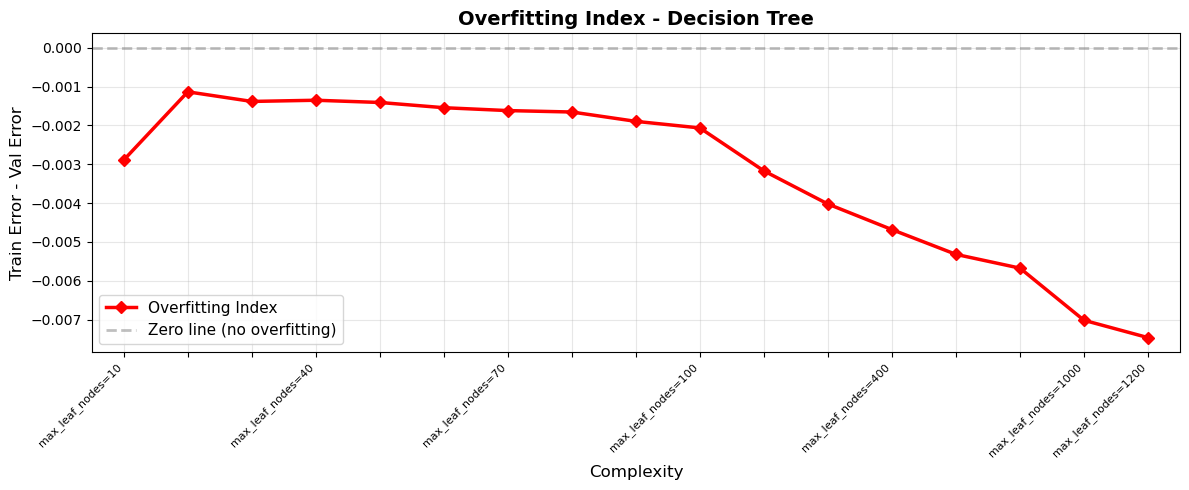


Decision Tree Analysis:
  Lowest complexity tested: max_leaf_nodes=10
    Train Error: 0.037887
    Val Error: 0.040776
  Optimal configuration: max_leaf_nodes=400
    Train Error: 0.003162
    Val Error: 0.007844
  Highest complexity tested: max_leaf_nodes=1200
    Train Error: 0.001123
    Val Error: 0.008588
    Overfitting Index: -0.007465
  U-shape detected: PARTIAL


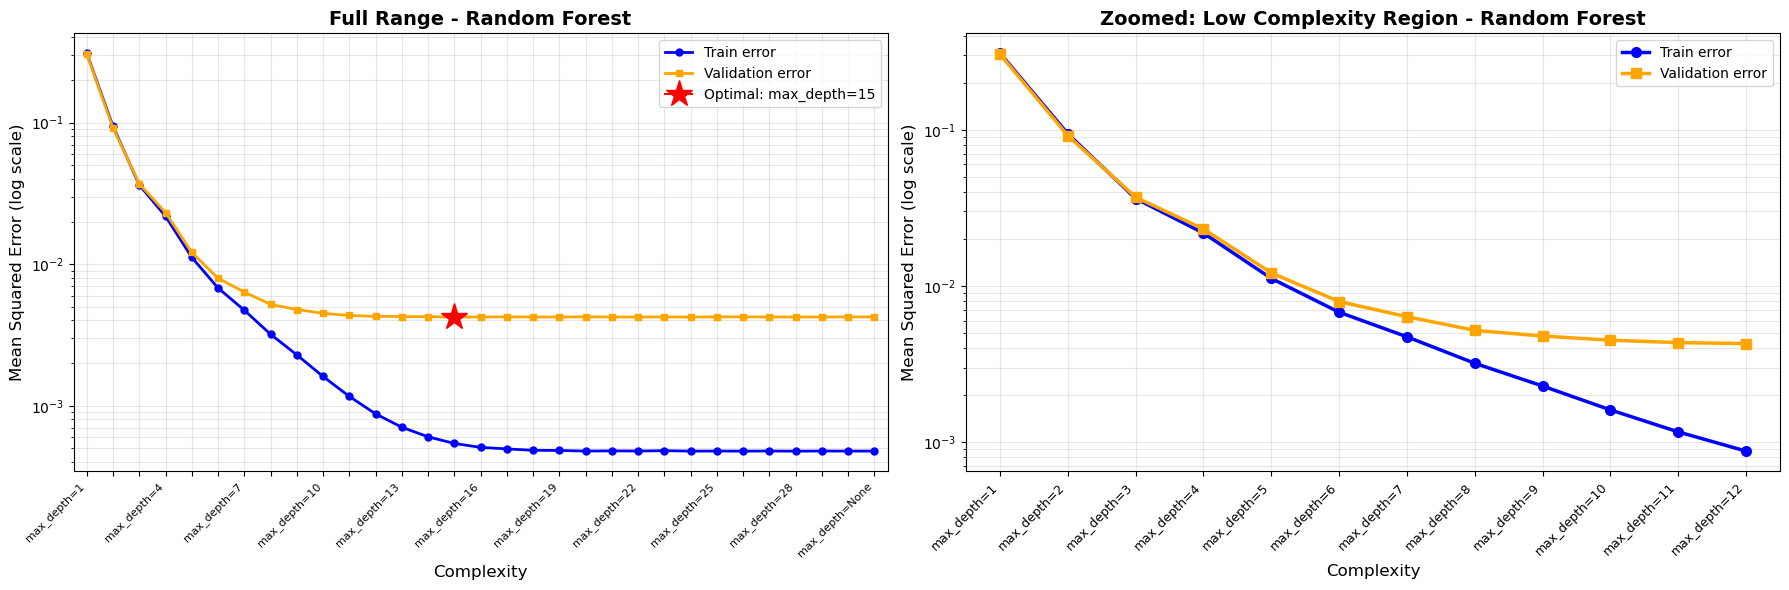

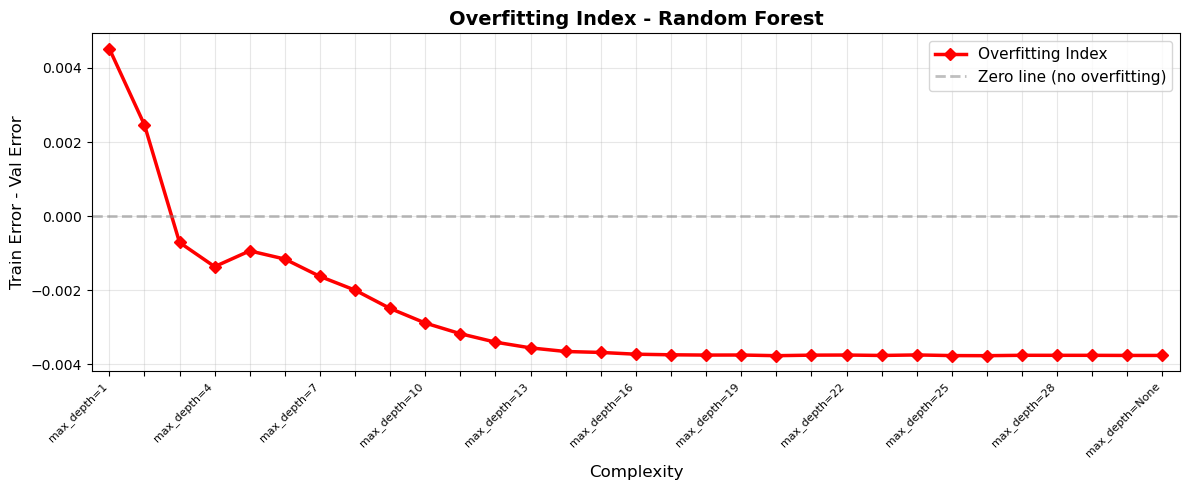


Random Forest Analysis:
  Lowest complexity tested: max_depth=1
    Train Error: 0.308884
    Val Error: 0.304365
  Optimal configuration: max_depth=15
    Train Error: 0.000541
    Val Error: 0.004221
  Highest complexity tested: max_depth=None
    Train Error: 0.000478
    Val Error: 0.004239
    Overfitting Index: -0.003761
  U-shape detected: PARTIAL


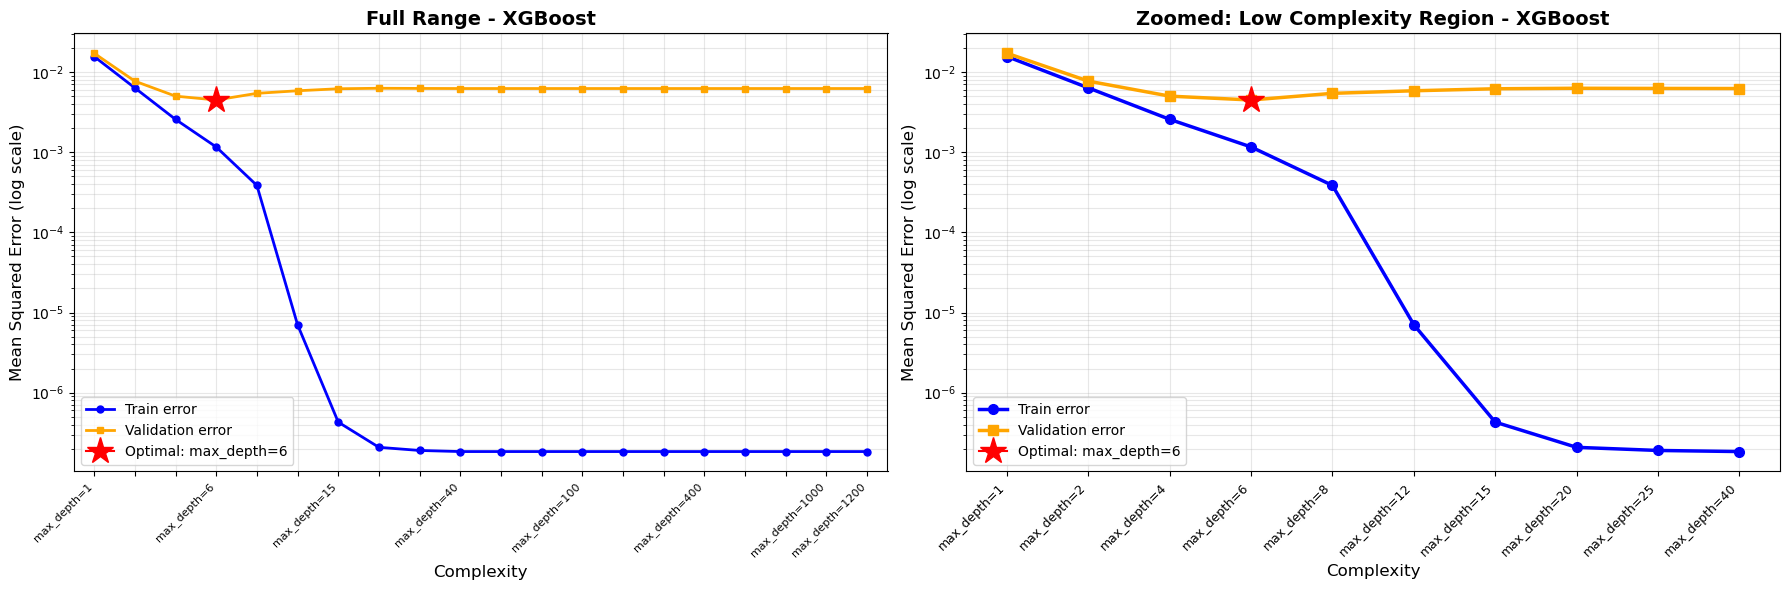

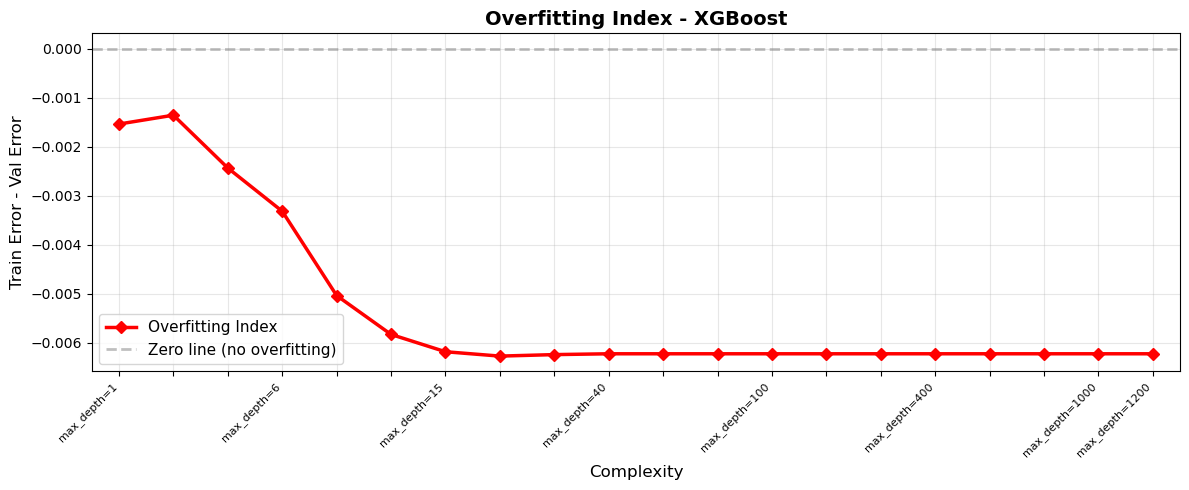


XGBoost Analysis:
  Lowest complexity tested: max_depth=1
    Train Error: 0.015619
    Val Error: 0.017157
  Optimal configuration: max_depth=6
    Train Error: 0.001162
    Val Error: 0.004480
  Highest complexity tested: max_depth=1200
    Train Error: 0.000000
    Val Error: 0.006227
    Overfitting Index: -0.006227
  U-shape detected: YES

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [109]:
from sklearn.preprocessing import PolynomialFeatures

ml_model_configs = {
    "Linear Regression": {"degree": list(range(1, 4))},
    "Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},  
    "Linear SVR": {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]},
    "Decision Tree": {"max_leaf_nodes": [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,1000,1200]},  
    "Random Forest": {"max_depth": list(range(1, 31)) + [None]},  
    "XGBoost": {"max_depth":[1,2,4,6,8,12,15,20,25,40,60,80,100,150,200,400,600,800,1000,1200]}
}

ml_complexity_rows = []

for model_name, param_dict in ml_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for val in values:
            # ALL models use SCALED data 
            X_sub = X_tr_sub_scaled
            y_sub = y_tr_sub_scaled
            X_val_sub_local = X_val_sub_scaled
            y_val_sub_local = y_val_sub_scaled
            
            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_leaf_nodes=val, random_state=42)

            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42, n_jobs=-1)

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == "Linear Regression":
                # For polynomial features on SCALED data
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err
                })
                continue
                
            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)
                
            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)
            
            # Fit model on SCALED data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors on SCALED data
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            ml_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

ml_cm_df = pd.DataFrame(ml_complexity_rows)
ml_cm_df["Complexity Level"] = ml_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ML MODELS - Complexity vs Error (ALL MODELS ON SCALED DATA):")
print("="*80)
display(ml_cm_df)

# Results
print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(ml_cm_df)

# Save
ml_cm_df.to_csv('ml_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'ml_complexity_ultra_low_results.csv'")
# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"], 
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"], 
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')
    
    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20, 
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else '' 
                   for i, label in enumerate(tick_labels)]
    
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]
    
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"], 
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"], 
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')
    
    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20, 
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"], 
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")




In [110]:
def get_epochs_for_complexity(complexity_level, total_levels):
    """
    Much more aggressive epoch scheduling to force overfitting
    """
    progress = complexity_level / total_levels
    
    if progress < 0.2:
        return 10   # Simple models - minimal training
    elif progress < 0.5:
        return 30   # Medium models
    else:
        return 100  # ← High complexity models MUST overfit with this many epochs


Training MLP...
  Progress: 1/29 - hidden_units=1
  Progress: 2/29 - hidden_units=2
  Progress: 3/29 - hidden_units=3
  Progress: 4/29 - hidden_units=4
  Progress: 5/29 - hidden_units=6
  Progress: 6/29 - hidden_units=8
  Progress: 7/29 - hidden_units=12
  Progress: 8/29 - hidden_units=16
  Progress: 9/29 - hidden_units=20
  Progress: 10/29 - hidden_units=24
  Progress: 11/29 - hidden_units=32
  Progress: 12/29 - hidden_units=40
  Progress: 13/29 - hidden_units=48
  Progress: 14/29 - hidden_units=64
  Progress: 15/29 - hidden_units=80
  Progress: 16/29 - hidden_units=96
  Progress: 17/29 - hidden_units=128
  Progress: 18/29 - hidden_units=160
  Progress: 19/29 - hidden_units=192
  Progress: 20/29 - hidden_units=256
  Progress: 21/29 - hidden_units=320
  Progress: 22/29 - hidden_units=384
  Progress: 23/29 - hidden_units=512
  Progress: 24/29 - hidden_units=768
  Progress: 25/29 - hidden_units=1024
  Progress: 26/29 - hidden_units=1536
  Progress: 27/29 - hidden_units=2048
  Progress: 

,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,MLP,hidden_units=1,0.015878,1.338946,-1.323067,1
1,MLP,hidden_units=2,0.025845,0.874510,-0.848664,2
2,MLP,hidden_units=3,0.028349,1.112514,-1.084165,3
3,MLP,hidden_units=4,0.011042,0.258192,-0.247150,4
4,MLP,hidden_units=6,0.010932,0.071497,-0.060565,5
...,...,...,...,...,...,...
71,Temporal CNN,filters=256,0.004214,0.033946,-0.029732,20
72,Temporal CNN,filters=384,0.004852,0.024246,-0.019395,21
73,Temporal CNN,filters=512,0.003385,0.019864,-0.016480,22
74,Temporal CNN,filters=768,0.005170,0.018173,-0.013003,23



✓ Results saved to 'nn_complexity_ultra_low_results.csv'

Generating plots...


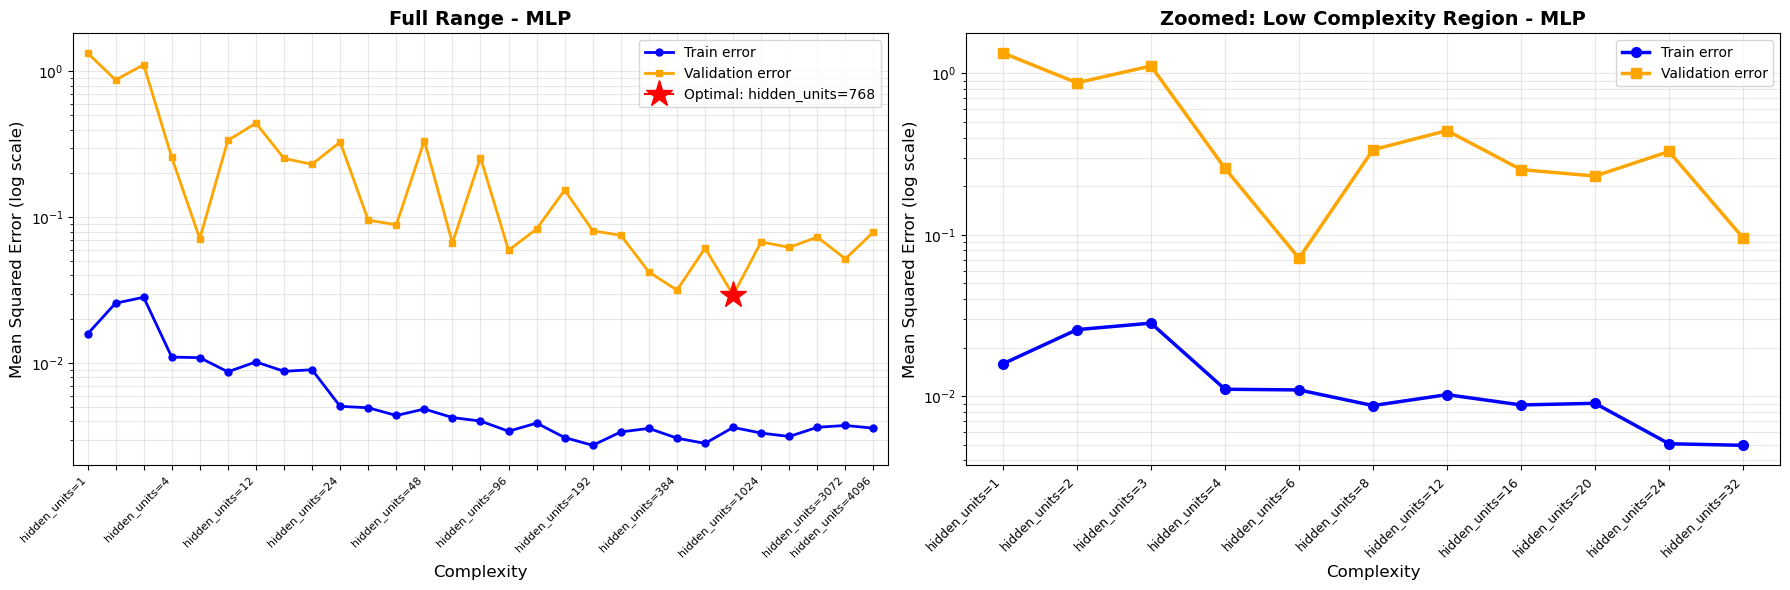

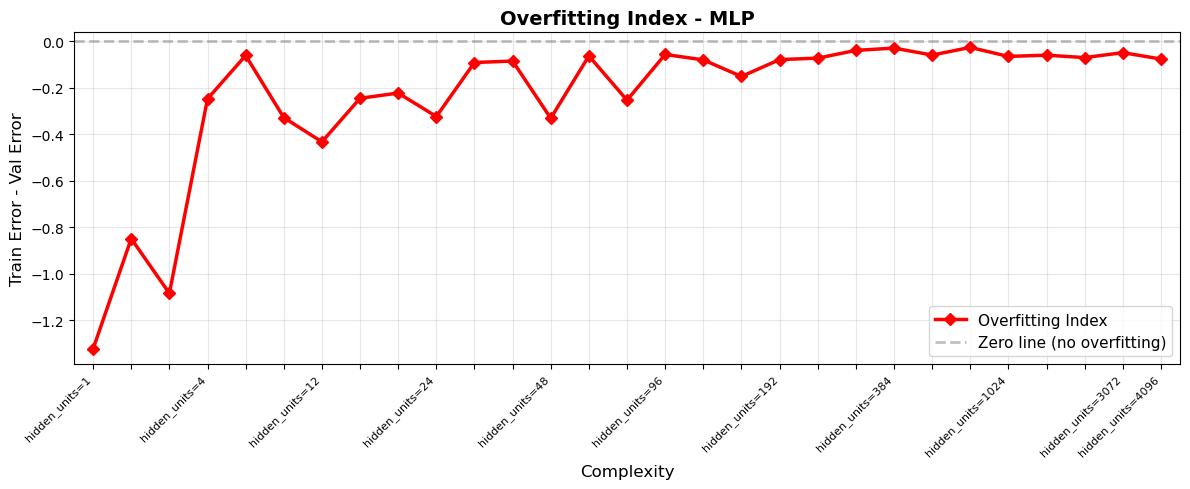


MLP Analysis:
  Lowest complexity tested: hidden_units=1
    Train Error: 0.015878
    Val Error: 1.338946
  Optimal configuration: hidden_units=768
    Train Error: 0.003640
    Val Error: 0.029418
  Highest complexity tested: hidden_units=4096
    Train Error: 0.003595
    Val Error: 0.079398
    Overfitting Index: -0.075803
  U-shape detected: YES


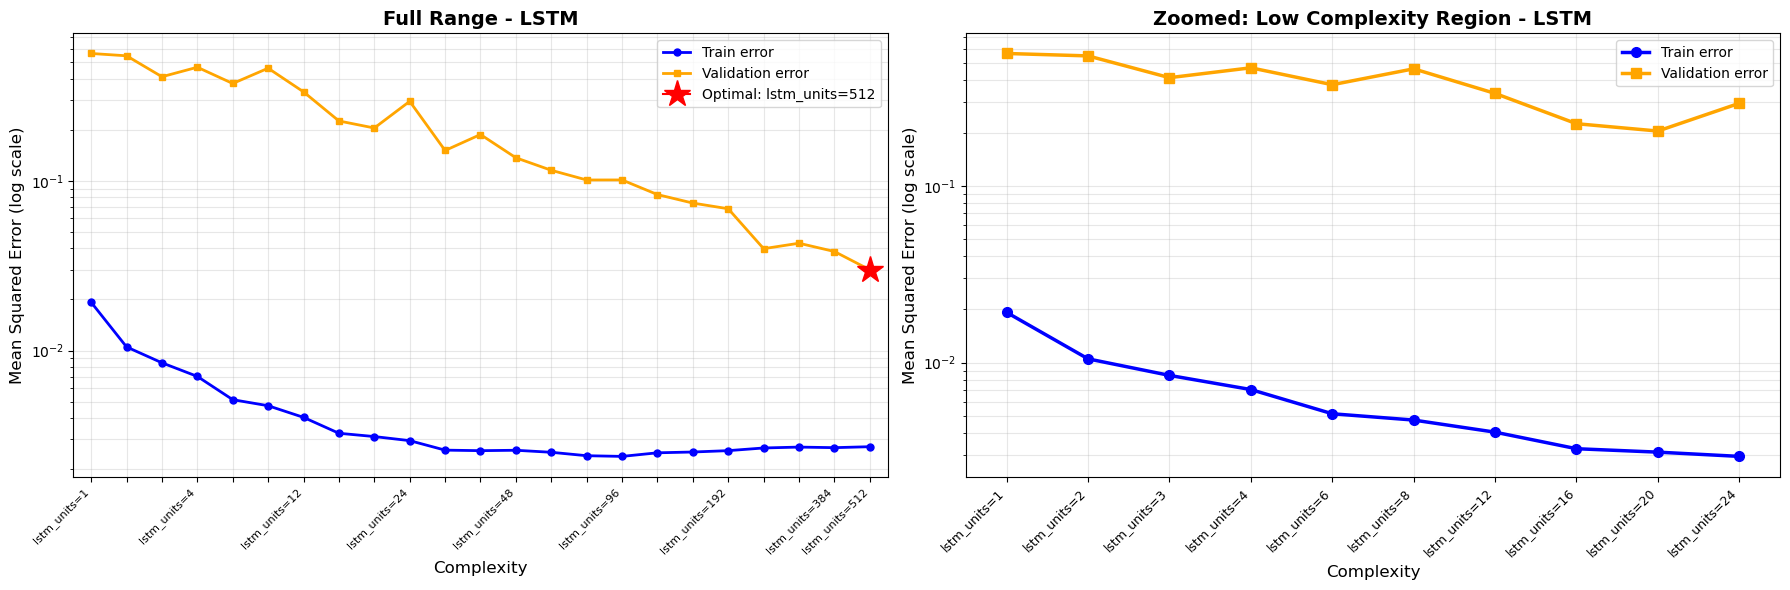

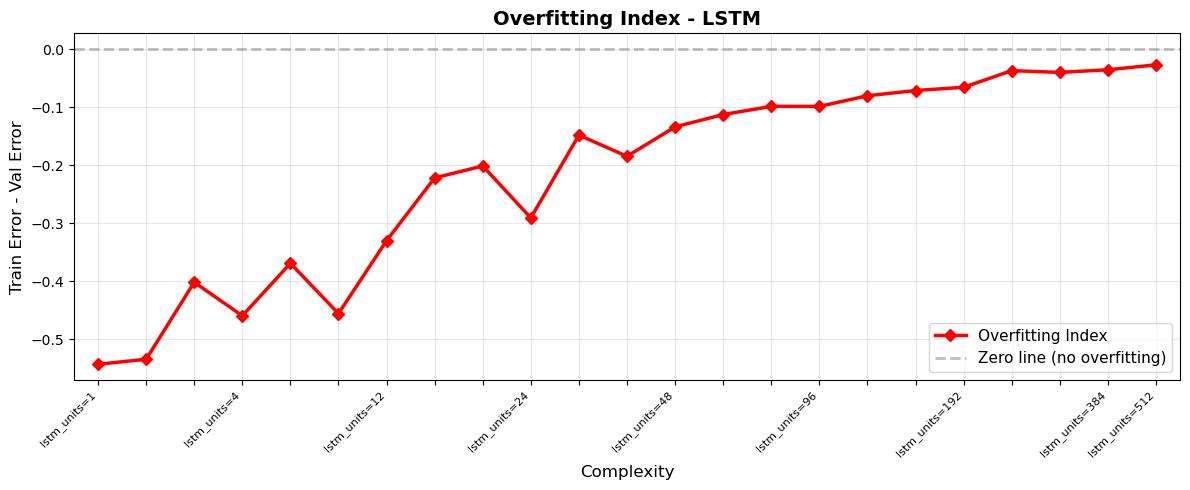


LSTM Analysis:
  Lowest complexity tested: lstm_units=1
    Train Error: 0.019235
    Val Error: 0.562591
  Optimal configuration: lstm_units=512
    Train Error: 0.002712
    Val Error: 0.029887
  Highest complexity tested: lstm_units=512
    Train Error: 0.002712
    Val Error: 0.029887
    Overfitting Index: -0.027175
  U-shape detected: PARTIAL


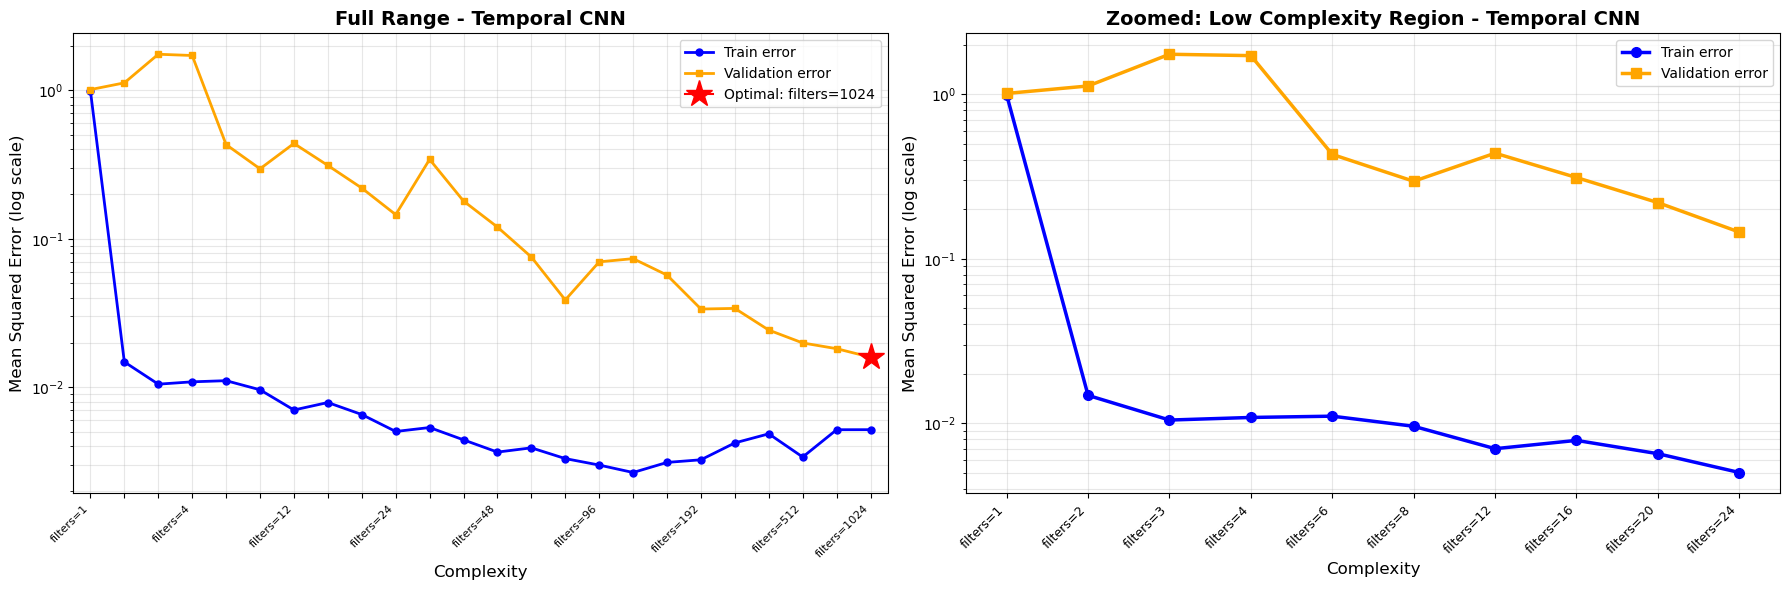

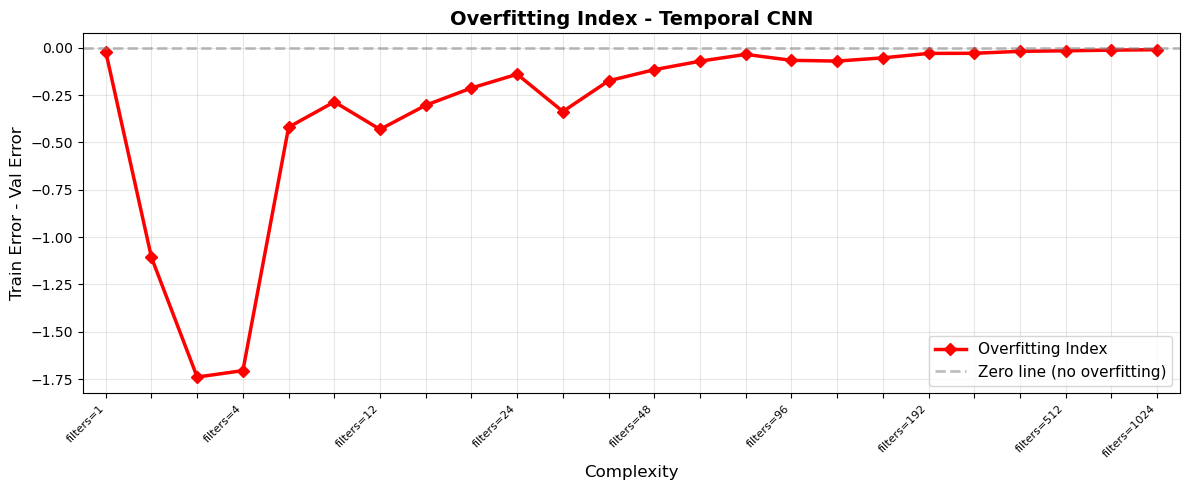


Temporal CNN Analysis:
  Lowest complexity tested: filters=1
    Train Error: 0.989740
    Val Error: 1.011072
  Optimal configuration: filters=1024
    Train Error: 0.005174
    Val Error: 0.015926
  Highest complexity tested: filters=1024
    Train Error: 0.005174
    Val Error: 0.015926
    Overfitting Index: -0.010752
  U-shape detected: PARTIAL

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [111]:
nn_model_configs = {
    # MLP: Start from 1 hidden unit
    "MLP": {"hidden_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 
                        128, 160, 192, 256, 320, 384, 512, 768, 1024, 
                        1536, 2048, 3072, 4096] },
    
    # LSTM: Start from 1 unit
    "LSTM": {"lstm_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 
                      128, 160, 192, 256, 320, 384, 512]},
    
    # Temporal CNN: Start from 1 filter
    "Temporal CNN": {"filters": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 
                   128, 160, 192, 256, 384, 512, 768, 1024]}
}

nn_complexity_rows = []

for model_name, param_dict in nn_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for i, val in enumerate(values, 1):
            print(f"  Progress: {i}/{len(values)} - {param_name}={val}")
            
            X_sub, y_sub = X_tr_sub_scaled, y_tr_sub_scaled
            X_val_sub_local, y_val_sub_local = X_val_sub_scaled, y_val_sub_scaled
            
            epochs = 10
            
            if model_name == "MLP":
                model = MLP_Wrapper(hidden_units=val, epochs=epochs)
            elif model_name == "LSTM":
                model = LSTM_Wrapper(units=val, epochs=epochs)
            elif model_name == "Temporal CNN":
                model = TemporalCNN_Wrapper(filters=val, epochs=epochs)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            nn_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Results
nn_cm_df = pd.DataFrame(nn_complexity_rows)
nn_cm_df["Complexity Level"] = nn_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(nn_cm_df)

# Save
nn_cm_df.to_csv('nn_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'nn_complexity_ultra_low_results.csv'")

# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in nn_cm_df["Model"].unique():
    temp = nn_cm_df[nn_cm_df["Model"] == model]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"], 
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"], 
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')
    
    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20, 
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else '' 
                   for i, label in enumerate(tick_labels)]
    
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]
    
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"], 
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"], 
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')
    
    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20, 
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"], 
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")




In [112]:
# error analysis

In [113]:
# feature importance

## D. 5-fold cv

In [ ]:
# # Part A - Step 4: 5-fold cross validation table
# def cross_val_summary(model, X, y, folds=5):
#     kf = KFold(n_splits=folds, shuffle=True, random_state=42)
#     r2_scores = []
#     mse_scores = []
#     for train_idx, val_idx in kf.split(X):
#         Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
#         ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             model.fit(Xtr, ytr)
#         preds = model.predict(Xv)
#         r2_scores.append(r2_score(yv, preds))
#         mse_scores.append(mean_squared_error(yv, preds))
#     return {"Mean R2": np.mean(r2_scores), "Std R2": np.std(r2_scores),
#             "Mean MSE": np.mean(mse_scores), "Std MSE": np.std(mse_scores)}

# cv_models = {
#     "Linear Regression": LinearRegression(),
#     "Linear SVR": LinearSVR(max_iter=5000),
#     "Decision Tree": DecisionTreeRegressor(random_state=42),
#     "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
#     "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
#                             tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist')
# }

# cv_rows = []
# for name, mod in cv_models.items():
#     summary = cross_val_summary(mod, X_train, y_train, folds=5)
#     row = {"Model": name}
#     row.update(summary)
#     cv_rows.append(row)

# result_table_6 = pd.DataFrame(cv_rows)
# print("Result Table 6 - 5-fold Cross Validation Summary:")
# display(result_table_6)


NameError: name 'X_train' is not defined

## Select winner models

In [ ]:
# df_table1 = result_table_1.copy()
# # Quick pick via lowest RMSE per category (simple heuristics):
# # Regression models: Linear Regression, Linear SVR, Ridge Regression
# regression_rows = df_table1[df_table1['Model'].isin(['Linear Regression','SVR','Ridge Regression'])]
# winner_regression = regression_rows.sort_values('RMSE').iloc[0]['Model'] if not regression_rows.empty else None

# tree_rows = df_table1[df_table1['Model'].isin(['Decision Tree','Random Forest','XGBoost'])]
# winner_tree = tree_rows.sort_values('RMSE').iloc[0]['Model'] if not tree_rows.empty else None

# neural_rows = df_table1[df_table1['Model'].isin(['MLP','LSTM','Temporal CNN'])]
# winner_neural = neural_rows.sort_values('RMSE').iloc[0]['Model'] if not neural_rows.empty else None

# print("Winner candidates (simple RMSE heuristic):")
# print("Regression winner:", winner_regression)
# print("Tree-based winner:", winner_tree)
# print("Neural winner:", winner_neural)


# Part B

## Comprehensive preprocessing

In [ ]:
# # ============================================================================
# # CONFIGURATION
# # ============================================================================

# OPTIMAL_FILTERS = 384 # From ultra-low complexity analysis
# EPOCHS = 50
# BATCH_SIZE = 32

# # Part A already includes:
# # - Lag features: [1, 2, 3, 6, 12, 24] hours
# # - Cyclical encoding: hour, day, month (sin/cos)

# # Part B adds:
# ROLLING_WINDOWS = [3, 6, 12, 24]  # Short-term trend capture
# WEATHER_PAIRS = [  # Domain knowledge interactions
#     ('temperature_2m', 'relativehumidity_2m'),
#     ('temperature_2m', 'wind_speed_10m'),
#     ('wind_speed_10m', 'wind_direction_10m')
# ]

# print(f"\nModel Configuration:")
# print(f"  Filters: {OPTIMAL_FILTERS}")
# print(f"  Epochs: {EPOCHS}")
# print(f"  Batch Size: {BATCH_SIZE}")

# # ============================================================================
# # HELPER FUNCTIONS
# # ============================================================================

# def clip_scaled_features(X_scaled, clip_value=5.0):
#     """Clip scaled features to prevent extreme predictions"""
#     X_clipped = np.clip(X_scaled, -clip_value, clip_value)
#     n_clipped = np.sum(np.abs(X_scaled) > clip_value)
#     if n_clipped > 0:
#         pct_clipped = 100 * n_clipped / X_scaled.size
#         print(f"  Clipped {n_clipped} values ({pct_clipped:.2f}%) to ±{clip_value}")
#     return X_clipped

# def create_rolling_features(df, target_col, windows):
#     """Create rolling statistics features"""
#     df_out = df.copy()
#     for window in windows:
#         df_out[f'{target_col}_rolling_mean_{window}'] = df_out[target_col].rolling(window=window).mean()
#         df_out[f'{target_col}_rolling_std_{window}'] = df_out[target_col].rolling(window=window).std()
#     return df_out

# def create_interaction_features(df, feature_pairs):
#     """Create interaction terms between feature pairs"""
#     df_out = df.copy()
#     for feat1, feat2 in feature_pairs:
#         if feat1 in df_out.columns and feat2 in df_out.columns:
#             df_out[f'{feat1}_x_{feat2}'] = df_out[feat1] * df_out[feat2]
#     return df_out

# # ============================================================================
# # SETUP GLOBAL TARGET SCALER
# # ============================================================================

# print("\n" + "="*80)
# print("SETTING UP GLOBAL TARGET SCALER")
# print("="*80)

# # Use the same scaler as Part A
# scaler_y_global = StandardScaler()
# scaler_y_global.fit(y_train_min.values.reshape(-1, 1))

# print(f"✓ Target scaler fitted on {len(y_train_min)} samples")
# print(f"  Mean: {scaler_y_global.mean_[0]:.2f} MW")
# print(f"  Std: {scaler_y_global.scale_[0]:.2f} MW")

# # Prepare dataframes with full context for feature engineering
# # Note: train_df_clipped and test_df already exist from Part A
# train_df_fe = train_df_clipped.copy()
# test_df_fe = test_df_clipped.copy()

# results = []

# # ============================================================================
# # STEP 0: BASELINE (Part A preprocessing)
# # ============================================================================

# print("\n" + "="*80)
# print("STEP 0: BASELINE (Part A Preprocessing)")
# print("="*80)
# print("Includes: IQR clip + Lag features + Cyclical encoding + Scaling + Post-clip")

# # Use the data from Part A (already has lags + cyclical encoding)
# X_train_step0 = X_train_min.copy()
# X_test_step0 = X_test_min.copy()
# y_train_step0_original = y_train_min.values
# y_test_step0_original = y_test_min.values

# # Scale features
# scaler_X_step0 = StandardScaler()
# X_train_step0_scaled = scaler_X_step0.fit_transform(X_train_step0)
# X_test_step0_scaled = scaler_X_step0.transform(X_test_step0)

# # Post-scaling clip
# print("\nClipping extreme scaled features...")
# X_train_step0_scaled = clip_scaled_features(X_train_step0_scaled, clip_value=5.0)
# X_test_step0_scaled = clip_scaled_features(X_test_step0_scaled, clip_value=5.0)

# # Scale target
# y_train_step0_scaled = scaler_y_global.transform(y_train_step0_original.reshape(-1, 1)).flatten()
# y_test_step0_scaled = scaler_y_global.transform(y_test_step0_original.reshape(-1, 1)).flatten()

# # Train
# print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
# model_step0 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
# model_step0.fit(X_train_step0_scaled, y_train_step0_scaled)

# # Predict
# y_train_pred_scaled = model_step0.predict(X_train_step0_scaled)
# y_test_pred_scaled = model_step0.predict(X_test_step0_scaled)

# # Inverse transform
# y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
# y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# # Metrics
# metrics_step0 = {
#     'Step': "Step 0: Baseline",
#     'Train MSE': mean_squared_error(y_train_step0_original, y_train_pred),
#     'Test MSE': mean_squared_error(y_test_step0_original, y_test_pred),
#     'Train RMSE': np.sqrt(mean_squared_error(y_train_step0_original, y_train_pred)),
#     'Test RMSE': np.sqrt(mean_squared_error(y_test_step0_original, y_test_pred)),
#     'Train MAE': mean_absolute_error(y_train_step0_original, y_train_pred),
#     'Test MAE': mean_absolute_error(y_test_step0_original, y_test_pred),
#     'Train R²': r2_score(y_train_step0_original, y_train_pred),
#     'Test R²': r2_score(y_test_step0_original, y_test_pred),
#     'Num Features': X_train_step0.shape[1]
# }
# results.append(metrics_step0)

# print(f"\nStep 0 Results:")
# print(f"  Features: {metrics_step0['Num Features']}")
# print(f"  Train RMSE: {metrics_step0['Train RMSE']:.2f} MW, R²: {metrics_step0['Train R²']:.6f}")
# print(f"  Test RMSE: {metrics_step0['Test RMSE']:.2f} MW, R²: {metrics_step0['Test R²']:.6f}")

# if metrics_step0['Test R²'] < 0:
#     print(f"  ⚠️  Negative R²! Check if Part A preprocessing was done correctly.")
# else:
#     print(f"  ✓ Positive R² - Baseline established!")

# # ============================================================================
# # STEP 1: BASELINE + ROLLING STATISTICS (FIXED)
# # ============================================================================

# print("\n" + "="*80)
# print("STEP 1: BASELINE + ROLLING STATISTICS (FIXED)")
# print("="*80)
# print(f"Adding rolling windows: {ROLLING_WINDOWS}")

# # Reconstruct lag/cyclical lists from X_train_min
# lag_features = [col for col in X_train_min.columns if 'lag' in col]
# cyclical_features = [col for col in X_train_min.columns if '_sin' in col or '_cos' in col]
# base_features = [col for col in X_train_min.columns if col not in lag_features + cyclical_features]

# print(f"Found {len(lag_features)} lag features, {len(cyclical_features)} cyclical features.")

# # Indices for selection (assume X_train_min/X_test_min index aligns to train_df_clipped/test_df_clipped)
# train_indices = X_train_min.index
# test_indices  = X_test_min.index

# # Work on copies from clipped data
# train_df_step1 = train_df_clipped.loc[train_indices].copy()
# test_df_step1  = test_df_clipped.loc[test_indices].copy()

# # ----- CRITICAL FIX: re-insert lag + cyclical columns into the dataframes -----
# # These features were present in X_train_min but not in train_df_clipped; copy them in (alignment by index).
# cols_to_inject = lag_features + cyclical_features
# missing_in_Xtrain = [c for c in cols_to_inject if c not in X_train_min.columns]
# if missing_in_Xtrain:
#     raise RuntimeError(f"Expected lag/cyclical cols missing from X_train_min: {missing_in_Xtrain}")

# # Inject for train
# train_df_step1[cols_to_inject] = X_train_min.loc[train_indices, cols_to_inject].values
# # Inject for test
# test_df_step1[cols_to_inject] = X_test_min.loc[test_indices, cols_to_inject].values

# # Sanity check: ensure all expected columns now exist
# expected_after_inject = list(X_train_min.columns)  # base + lag + cyclical as used below
# still_missing_train = [c for c in expected_after_inject if c not in train_df_step1.columns]
# still_missing_test  = [c for c in expected_after_inject if c not in test_df_step1.columns]
# if still_missing_train or still_missing_test:
#     print("WARNING: still missing columns after injection.")
#     print(" missing in train_df_step1:", still_missing_train)
#     print(" missing in test_df_step1: ", still_missing_test)
#     # continue but will likely error later; user can inspect the prints

# # Create rolling features on the full df
# train_df_step1 = create_rolling_features(train_df_step1, target, ROLLING_WINDOWS)
# test_df_step1  = create_rolling_features(test_df_step1,  target, ROLLING_WINDOWS)

# # Get rolling feature columns
# rolling_feature_cols = [col for col in train_df_step1.columns if 'rolling_mean' in col or 'rolling_std' in col]
# print(f"✓ Created {len(rolling_feature_cols)} rolling features: {rolling_feature_cols}")

# # Combine features: (all columns from X_train_min) + rolling
# step1_feature_cols = list(X_train_min.columns) + rolling_feature_cols

# # Final check: which of step1_feature_cols are actually in train_df_step1
# not_present = [c for c in step1_feature_cols if c not in train_df_step1.columns]
# if not_present:
#     print("ERROR: The following expected columns are NOT present in train_df_step1 (will dropna -> fail):")
#     print(not_present)
#     # Try to continue by removing non-present columns from the feature list so dropna won't KeyError
#     step1_feature_cols = [c for c in step1_feature_cols if c in train_df_step1.columns]
#     print("Adjusted step1_feature_cols to existing columns. Proceeding...")

# # Drop NaNs created by rolling (and any other missing)
# drop_subset = step1_feature_cols + [target]
# train_df_step1 = train_df_step1.dropna(subset=drop_subset)
# test_df_step1  = test_df_step1.dropna(subset=drop_subset)

# # Build X/y
# X_train_step1 = train_df_step1[step1_feature_cols]
# X_test_step1  = test_df_step1[step1_feature_cols]
# y_train_step1_original = train_df_step1[target].values
# y_test_step1_original  = test_df_step1[target].values

# print(f"✓ After dropna: Train rows = {len(train_df_step1)}, Test rows = {len(test_df_step1)}")
# print(f"  Num features used: {len(step1_feature_cols)} (+{len(rolling_feature_cols)} rolling)")

# # Scale and clip as before
# scaler_X_step1 = StandardScaler()
# X_train_step1_scaled = scaler_X_step1.fit_transform(X_train_step1)
# X_test_step1_scaled  = scaler_X_step1.transform(X_test_step1)

# print("\nClipping extreme scaled features...")
# X_train_step1_scaled = clip_scaled_features(X_train_step1_scaled, clip_value=5.0)
# X_test_step1_scaled  = clip_scaled_features(X_test_step1_scaled, clip_value=5.0)

# y_train_step1_scaled = scaler_y_global.transform(y_train_step1_original.reshape(-1, 1)).flatten()
# y_test_step1_scaled  = scaler_y_global.transform(y_test_step1_original.reshape(-1, 1)).flatten()

# # Train
# print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
# model_step1 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
# model_step1.fit(X_train_step1_scaled, y_train_step1_scaled)

# # Predict + metrics (same as before)
# y_train_pred_scaled = model_step1.predict(X_train_step1_scaled)
# y_test_pred_scaled  = model_step1.predict(X_test_step1_scaled)

# y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
# y_test_pred  = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# metrics_step1 = {
#     'Step': "Step 1: + Rolling Stats",
#     'Train MSE': mean_squared_error(y_train_step1_original, y_train_pred),
#     'Test MSE': mean_squared_error(y_test_step1_original, y_test_pred),
#     'Train RMSE': np.sqrt(mean_squared_error(y_train_step1_original, y_train_pred)),
#     'Test RMSE': np.sqrt(mean_squared_error(y_test_step1_original, y_test_pred)),
#     'Train MAE': mean_absolute_error(y_train_step1_original, y_train_pred),
#     'Test MAE': mean_absolute_error(y_test_step1_original, y_test_pred),
#     'Train R²': r2_score(y_train_step1_original, y_train_pred),
#     'Test R²': r2_score(y_test_step1_original, y_test_pred),
#     'Num Features': X_train_step1.shape[1]
# }
# results.append(metrics_step1)

# print(f"\nStep 1 Results:")
# print(f"  Features: {metrics_step1['Num Features']} (+{metrics_step1['Num Features'] - metrics_step0['Num Features']})")
# print(f"  Test RMSE: {metrics_step1['Test RMSE']:.2f} MW (Δ: {metrics_step1['Test RMSE'] - metrics_step0['Test RMSE']:.2f})")
# print(f"  Test R²: {metrics_step1['Test R²']:.6f}")
# # ============================================================================
# # STEP 2: ADD WEATHER INTERACTIONS
# # ============================================================================

# print("\n" + "="*80)
# print("STEP 2: STEP 1 + WEATHER INTERACTIONS")
# print("="*80)
# print(f"Adding interactions: {WEATHER_PAIRS}")

# # Create interactions on the step1 dataframes
# train_df_step2 = create_interaction_features(train_df_step1, WEATHER_PAIRS)
# test_df_step2 = create_interaction_features(test_df_step1, WEATHER_PAIRS)

# # Get interaction feature columns
# interaction_feature_cols = [col for col in train_df_step2.columns if '_x_' in col]
# step2_feature_cols = step1_feature_cols + interaction_feature_cols

# X_train_step2 = train_df_step2[step2_feature_cols]
# X_test_step2 = test_df_step2[step2_feature_cols]
# y_train_step2_original = train_df_step2[target].values
# y_test_step2_original = test_df_step2[target].values

# print(f"✓ Added {len(interaction_feature_cols)} interaction features")

# # Scale and clip
# scaler_X_step2 = StandardScaler()
# X_train_step2_scaled = scaler_X_step2.fit_transform(X_train_step2)
# X_test_step2_scaled = scaler_X_step2.transform(X_test_step2)

# print("\nClipping extreme scaled features...")
# X_train_step2_scaled = clip_scaled_features(X_train_step2_scaled, clip_value=5.0)
# X_test_step2_scaled = clip_scaled_features(X_test_step2_scaled, clip_value=5.0)

# y_train_step2_scaled = scaler_y_global.transform(y_train_step2_original.reshape(-1, 1)).flatten()
# y_test_step2_scaled = scaler_y_global.transform(y_test_step2_original.reshape(-1, 1)).flatten()

# # Train
# print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
# model_step2 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
# model_step2.fit(X_train_step2_scaled, y_train_step2_scaled)

# # Predict
# y_train_pred_scaled = model_step2.predict(X_train_step2_scaled)
# y_test_pred_scaled = model_step2.predict(X_test_step2_scaled)
# y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
# y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# # Metrics
# metrics_step2 = {
#     'Step': "Step 2: + Weather Interactions",
#     'Train MSE': mean_squared_error(y_train_step2_original, y_train_pred),
#     'Test MSE': mean_squared_error(y_test_step2_original, y_test_pred),
#     'Train RMSE': np.sqrt(mean_squared_error(y_train_step2_original, y_train_pred)),
#     'Test RMSE': np.sqrt(mean_squared_error(y_test_step2_original, y_test_pred)),
#     'Train MAE': mean_absolute_error(y_train_step2_original, y_train_pred),
#     'Test MAE': mean_absolute_error(y_test_step2_original, y_test_pred),
#     'Train R²': r2_score(y_train_step2_original, y_train_pred),
#     'Test R²': r2_score(y_test_step2_original, y_test_pred),
#     'Num Features': X_train_step2.shape[1]
# }
# results.append(metrics_step2)

# print(f"\nStep 2 Results:")
# print(f"  Features: {metrics_step2['Num Features']} (+{metrics_step2['Num Features'] - metrics_step1['Num Features']})")
# print(f"  Test RMSE: {metrics_step2['Test RMSE']:.2f} MW (Δ: {metrics_step2['Test RMSE'] - metrics_step1['Test RMSE']:.2f})")
# print(f"  Test R²: {metrics_step2['Test R²']:.6f}")

# # ============================================================================
# # RESULTS SUMMARY
# # ============================================================================

# print("\n" + "="*80)
# print("COMPLETE RESULTS")
# print("="*80)

# results_df = pd.DataFrame(results)
# display(results_df)

# results_df.to_csv('part_b_step1_results.csv', index=False)
# print("\n✓ Results saved to 'part_b_step1_results.csv'")

# best_idx = results_df['Test RMSE'].idxmin()
# best_step = results_df.loc[best_idx, 'Step']
# best_rmse = results_df.loc[best_idx, 'Test RMSE']

# print(f"\n🏆 BEST PREPROCESSING STEP: {best_step}")
# print(f"   Test RMSE: {best_rmse:.2f} MW")
# print(f"   Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
# print(f"   Features: {int(results_df.loc[best_idx, 'Num Features'])}")

# # ============================================================================
# # VISUALIZATIONS
# # ============================================================================

# print("\n" + "="*80)
# print("GENERATING VISUALIZATIONS")
# print("="*80)

# fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # Plot 1: Test RMSE
# ax1 = axes[0, 0]
# steps = results_df['Step']
# rmse_values = results_df['Test RMSE']
# colors = ['red' if i == best_idx else 'steelblue' for i in range(len(steps))]
# ax1.bar(range(len(steps)), rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
# ax1.set_xticks(range(len(steps)))
# ax1.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
# ax1.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
# ax1.set_title('Test RMSE by Preprocessing Step', fontsize=15, fontweight='bold')
# ax1.grid(axis='y', alpha=0.3)
# for i, v in enumerate(rmse_values):
#     ax1.text(i, v + 50, f'{v:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# # Plot 2: Test R²
# ax2 = axes[0, 1]
# r2_values = results_df['Test R²']
# colors = ['green' if i == best_idx else 'steelblue' for i in range(len(steps))]
# ax2.bar(range(len(steps)), r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
# ax2.set_xticks(range(len(steps)))
# ax2.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
# ax2.set_ylabel('Test R²', fontsize=13, fontweight='bold')
# ax2.set_title('Test R² by Preprocessing Step', fontsize=15, fontweight='bold')
# ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='R²=0.9')
# ax2.grid(axis='y', alpha=0.3)
# ax2.legend(fontsize=11)
# for i, v in enumerate(r2_values):
#     ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# # Plot 3: Feature Count vs Performance
# ax3 = axes[1, 0]
# feature_counts = results_df['Num Features']
# ax3.plot(feature_counts, rmse_values, marker='o', markersize=12, linewidth=3, color='steelblue')
# for i, (fc, rmse) in enumerate(zip(feature_counts, rmse_values)):
#     color = 'red' if i == best_idx else 'steelblue'
#     ax3.scatter(fc, rmse, s=250, c=color, zorder=5, edgecolors='black', linewidth=2)
# ax3.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
# ax3.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
# ax3.set_title('Model Complexity vs Performance', fontsize=15, fontweight='bold')
# ax3.grid(alpha=0.3)

# # Plot 4: Improvement over Baseline
# ax4 = axes[1, 1]
# baseline_rmse = results_df.loc[0, 'Test RMSE']
# improvements = [(baseline_rmse - rmse) / baseline_rmse * 100 for rmse in rmse_values]
# colors = ['green' if imp > 0 else 'red' for imp in improvements]
# ax4.bar(range(len(steps)), improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
# ax4.set_xticks(range(len(steps)))
# ax4.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
# ax4.set_ylabel('Improvement over Baseline (%)', fontsize=13, fontweight='bold')
# ax4.set_title('RMSE Improvement Relative to Baseline', fontsize=15, fontweight='bold')
# ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
# ax4.grid(axis='y', alpha=0.3)
# for i, v in enumerate(improvements):
#     y_pos = v + 1 if v > 0 else v - 1
#     ax4.text(i, y_pos, f'{v:.1f}%', ha='center', 
#              va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

# plt.tight_layout()
# plt.savefig('part_b_step1_comparison.png', dpi=150, bbox_inches='tight')
# plt.show()

# print("✓ Saved visualization: part_b_step1_comparison.png")

# print("\n" + "="*80)
# print("✅ PART B STEP 1 COMPLETE!")
# print("="*80)
# print(f"\nRecommendation: Use {best_step} for Part B Step 2")
# print(f"  - Best Test RMSE: {best_rmse:.2f} MW")
# print(f"  - Best Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
# print(f"  - Features: {int(results_df.loc[best_idx, 'Num Features'])}")




In [ ]:
# print("=== train_df_step1 columns ===")
# print(train_df_step1.columns.tolist())


In [ ]:
# print(X_train_min.columns.tolist())

## Hyperparameter tuning

### Linear SVR

In [128]:
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from scipy.stats import loguniform, uniform
#SVR": LinearSVR(max_iter=5000)
n_splits=5
n_iter=50
random_seed=42

svr_model=LinearSVR(max_iter=10000,dual='auto',random_state =random_seed)

param_distributions={
    'C':[0.01],
    'epsilon':loguniform(1e-4,1e-1),
    'loss':['squared_epsilon_insensitive', 'epsilon_insensitive']
}
tscv = TimeSeriesSplit(n_splits=n_splits)

random_search = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=random_seed,
    verbose=1,
    n_jobs=-1
)
print(f"Starting RandomizedSearchCV for LinearSVR with {n_iter} iterations...")
random_search.fit(X_tr_sub_scaled, y_tr_sub_scaled)
#best_svr = random_search.best_estimator_

#best_score = np.sqrt(-random_search.best_score_)

#result
best_params = random_search.best_params_
best_cv_rmse = np.sqrt(-random_search.best_score_)

#best_params_svr = pd.Series(random_search.best_params_).to_frame(name='Best Value')





Starting RandomizedSearchCV for LinearSVR with 50 iterations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [129]:


best_svr_model=LinearSVR(
    max_iter=10000,
    dual='auto',
    random_state=random_seed,
    C=best_params['C'],
    epsilon=best_params['epsilon'],
    loss=best_params['loss']
)

best_svr_model.fit(data_full['X_train_scaled'],data_full['y_train_scaled'])

LinearSVR(C=0.01, epsilon=np.float64(0.009717775305059635), max_iter=10000,
          random_state=42)

In [130]:
y_pred_train_svr_scaled=best_svr_model.predict(data_full['X_train_scaled'])
y_pred_test_svr_scaled = best_svr_model.predict(data_full['X_test_scaled'])


y_test_svr = scalers_full['scaler_y'].inverse_transform(data_full['y_test_scaled'].reshape(-1, 1)).flatten()
y_pred_test_svr= scalers_full['scaler_y'].inverse_transform(y_pred_test_svr_scaled.reshape(-1, 1)).flatten()
y_pred_train_svr=  scalers_full['scaler_y'].inverse_transform(y_pred_train_svr_scaled.reshape(-1, 1)).flatten()
y_train_svr= scalers_full['scaler_y'].inverse_transform(data_full['y_train_scaled'].reshape(-1, 1)).flatten()

R2_TRAIN = r2_score(y_train_svr, y_pred_train_svr)
R2_TEST = r2_score(y_test_svr, y_pred_test_svr)

mae_svr = mean_absolute_error(y_test_svr, y_pred_test_svr)
rmse_svr = sqrt(mean_squared_error(y_test_svr, y_pred_test_svr))


TUNE_SVR_performance=[]
TUNE_SVR_performance.append({
    'Best C': f"{best_params['C']:.4f}",
    'Best Epsilon': f"{best_params['epsilon']:.6f}", # Using more decimal places for epsilon
    'Best Loss': best_params['loss'],
    'Train R2': f"{R2_TRAIN:.4f}",
    'Val RMSE (Tuning)': f"{best_cv_rmse:.3f}",
    'Test R2': f"{R2_TEST:.4f}",
    'MAE (MW)': f"{mae_svr:.3f}",
    'RMSE (MW)': f"{rmse_svr:.3f}", 
})

svr_result_df=pd.DataFrame(TUNE_SVR_performance)
display(svr_result_df)

,Best C,Best Epsilon,Best Loss,Train R2,Val RMSE (Tuning),Test R2,MAE (MW),RMSE (MW)
0,0.0100,0.009718,epsilon_insensitive,0.9959,0.076,0.9939,339.906,425.642


### RF

### TCNN

In [131]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
FIXED_FILTERS=385
class TCNN_TUNE:
    def __init__(self, input_shape, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32,learning_rate=0.001, dropout_rate=0.0):
        self.input_shape = input_shape
        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate 
        self.dropout_rate = dropout_rate
        self.model = self.build_model() 

    def build_model(self):
        # model = Sequential()
        # model.add(Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape))
        #    # Conv1D(max(1, self.filters//2), kernel_size=1, activation='relu'),
        # for i in range(1, self.n_layers):
        #     current_filters = max(64, int(self.filters * (0.75**i)))    #option
        #     #current_filters = max(1, self.filters // (2**i))
        #     model.add(Conv1D(current_filters, kernel_size=1, activation='relu'))
            
        # model.add(Dropout(self.dropout_rate)) 
            
        # model.add(Flatten())
        # model.add(Dense(1))
        
        

        # #optimizer = Adam(learning_rate=self.learning_rate) #option
        # optimizer = Adam(learning_rate=self.learning_rate, clipvalue=1.0)
        # model.compile(optimizer=optimizer, loss='mse')
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters // 2), kernel_size=1, activation='relu'),
            Dropout(self.dropout_rate),
            Flatten(),
            Dense(1)
        ])
        optimizer = Adam(learning_rate=self.learning_rate, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
        
        return model
    
    def fit_predict(self, X_train, y_train, X_test):
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5,             
            restore_best_weights=True
        )

        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, 
                       validation_split=0.2, # Added validation split for monitoring
                       callbacks=[early_stopping], # Used Early Stopping
                       verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

class TCNN_TUNE_Wrapper(BaseEstimator,RegressorMixin):
    def __init__(self, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32, 
                 learning_rate=0.001, dropout_rate=0.0):
        
        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.cnn_instance = None

    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1) 
        input_shape = X_cnn.shape[1:] 

 
        self.cnn_instance = TCNN_TUNE(
            input_shape=input_shape,
            filters=self.filters,
            n_layers=self.n_layers,  #add
            epochs=self.epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate, 
            dropout_rate=self.dropout_rate    
        )
        
        # Train the model
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self
    
    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
            
        # Data conversion for prediction
        X_cnn = np.expand_dims(X, axis=1)
        

        # y_pred, _, _ = self.cnn_instance.fit_predict(X_train=X_cnn, y_train=np.zeros_like(X_cnn), X_test=X_cnn)
        # return y_pred.flatten()
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred
    
    

    def get_params(self, deep=True):
        return {
            'filters': self.filters, 'epochs': self.epochs, 'batch_size': self.batch_size,
            'learning_rate': self.learning_rate, 'dropout_rate': self.dropout_rate
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self




    
    
    




In [ ]:
# subsample_ratio = 0.3
# N = int(len(X_train) * subsample_ratio)


# #for hyperparameter tunnig
# X_tr_sub_hyp = X_train_step1_scaled[:N].copy()
# y_tr_sub_hyp  = y_train_step1_scaled[:N].copy()

# X_test_sub_hyp=X_test_step1_scaled[:N].copy()
# y_test_sub_hyp=y_test_step1_scaled[:N].copy()



In [132]:
#X_train_step1_scaled
#y_train_step1_scaled
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)
np.random.seed(42)


FIXED_FILTERS = 1024

param_distributions = {
    # Optimization & Training
    'batch_size': [32, 64, 128,256,512], 
    'learning_rate': loguniform(1e-6, 1e-2), 
    #add
    'n_layers':[1,2,3,4,5,6],
    
    # Regularization
    'dropout_rate': uniform(loc=0.0, scale=0.7), 
    
    # Fixed parameters 
    'filters': [FIXED_FILTERS],
    'epochs': [50] 
}

N_ITER_TRIALS = 10 
CV_FOLDS = 3
TOTAL_MODELS = N_ITER_TRIALS * CV_FOLDS

print(f"Starting Focused Random Search")
print(f"Starting Focused Random Search (Filters={FIXED_FILTERS})")
print(f"Total models to train: {TOTAL_MODELS} ({N_ITER_TRIALS} trials x {CV_FOLDS} folds)")
print("-" * 50)

tcnn_base = TCNN_TUNE_Wrapper(filters=FIXED_FILTERS, epochs=50)
random_search = RandomizedSearchCV(
    estimator=tcnn_base, 
    param_distributions=param_distributions, 
    n_iter=N_ITER_TRIALS, 
    scoring='neg_mean_squared_error',
    cv=CV_FOLDS,          
    verbose=2, 
    n_jobs=-1,
    random_state=42 
)

random_search.fit(X_tr_sub_scaled, y_tr_sub_scaled)



# --- 4. RESULTS ---
best_params = random_search.best_params_
BEST_LR = best_params['learning_rate']
BEST_BATCH_SIZE = best_params['batch_size']
BEST_DROPOUT = best_params['dropout_rate']
FIXED_FILTERS = best_params['filters']
BEST_LAYERS=best_params['n_layers']

best_params_df = pd.Series(random_search.best_params_).to_frame(name='Best Value')
print("\nBest Hyperparameters Found:")
print(best_params_df.to_markdown())




Starting Focused Random Search
Starting Focused Random Search (Filters=1024)
Total models to train: 30 (10 trials x 3 folds)
--------------------------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
from math import sqrt

# to use best fit parameter (tcnn)
print("TRAINING FINAL MODEL ON FULL DATA")
Best_TCNN_Wrapper = TCNN_TUNE_Wrapper(
    filters=FIXED_FILTERS, 
    n_layers=BEST_LAYERS, #add
    epochs=best_params['epochs'], 
    batch_size=BEST_BATCH_SIZE, 
    learning_rate=BEST_LR,
    dropout_rate=BEST_DROPOUT
)

Best_TCNN=Best_TCNN_Wrapper.fit(
    data_full['X_train_scaled'], #add
    data_full['y_train_scaled']

)



y_pred_train_hyp_scaled=Best_TCNN_Wrapper.predict(data_full['X_train_scaled'])
y_pred_test_hyp_scaled = Best_TCNN_Wrapper.predict(data_full['X_test_scaled'])

# R2_TRAIN = r2_score(y_train_step1_scaled, y_pred_train_hyp_scaled)
# R2_TEST = r2_score(y_test_step1_scaled, y_pred_test_hyp_scaled)

y_test_hyp = scalers_full['scaler_y'].inverse_transform(data_full['y_test_scaled'].reshape(-1, 1)).flatten()
y_pred_test_hyp= scalers_full['scaler_y'].inverse_transform(y_pred_test_hyp_scaled.reshape(-1, 1)).flatten()
y_pred_train_hyp=  scalers_full['scaler_y'].inverse_transform(y_pred_train_hyp_scaled.reshape(-1, 1)).flatten()
y_train_hyp= scalers_full['scaler_y'].inverse_transform(data_full['y_train_scaled'].reshape(-1, 1)).flatten()

R2_TRAIN = r2_score(y_train_hyp, y_pred_train_hyp)
R2_TEST = r2_score(y_test_hyp, y_pred_test_hyp)

mae_hyp = mean_absolute_error(y_test_hyp, y_pred_test_hyp)
rmse_hyp = sqrt(mean_squared_error(y_test_hyp, y_pred_test_hyp))


TUNE_TCNN_performance=[]
TUNE_TCNN_performance.append({
    # Architecture and Hyperparameters
    #'Layers': N_LAYERS,
    #'Conv1D Filters': f"{FILTERS_L1} / {FILTERS_L2}",
    'Filters':best_params['filters'],
    'Layers':best_params['n_layers'], #add
    'Batch size': best_params['batch_size'],
    'Learning rate': f"{best_params['learning_rate']:.2e}", 
    'Dropout': f"{best_params['dropout_rate']:.4f}",
    'Epoch': best_params['epochs'], 
    'Train R2': f"{R2_TRAIN:.4f}",
    #'Val R2': 'Internal (0.2 Split)', 
    'Test R2': f"{R2_TEST:.4f}",
    'MAE (MW)': f"{mae_hyp:.3f}",
    'RMSE (MW)': f"{rmse_hyp:.3f}", 
})

tcnn_result_df=pd.DataFrame(TUNE_TCNN_performance)
display(tcnn_result_df)





TRAINING FINAL MODEL ON FULL DATA
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


,Filters,Layers,Batch size,Learning rate,Dropout,Epoch,Train R2,Test R2,MAE (MW),RMSE (MW)
0,1024,6,512,2.14e-03,0.6789,50,0.9922,0.9890,444.593,571.873


### LSTM

## Ensemble Model